In [2]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Set Seed
torch.manual_seed(22)

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
# Load in data
head = Path.cwd().parents[3]
source_img_path = head / 'data/mb_lenscolor_source/mb_lenscolor_source.npy'
target_img_path = head / 'data/mb_lenscolor_target/mb_lenscolor_target.npy'
source_meta = head / 'data/mb_lenscolor_source/mb_lenscolor_source_metadata.csv'
target_meta = head / 'data/mb_lenscolor_target/mb_lenscolor_target_metadata.csv'
batch_size = 32
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)

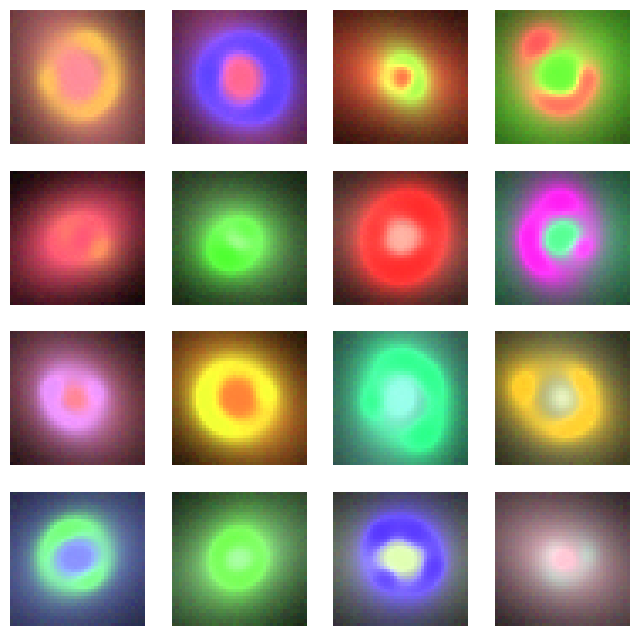

In [4]:
# Visualize source data
visualize_data(source_data)

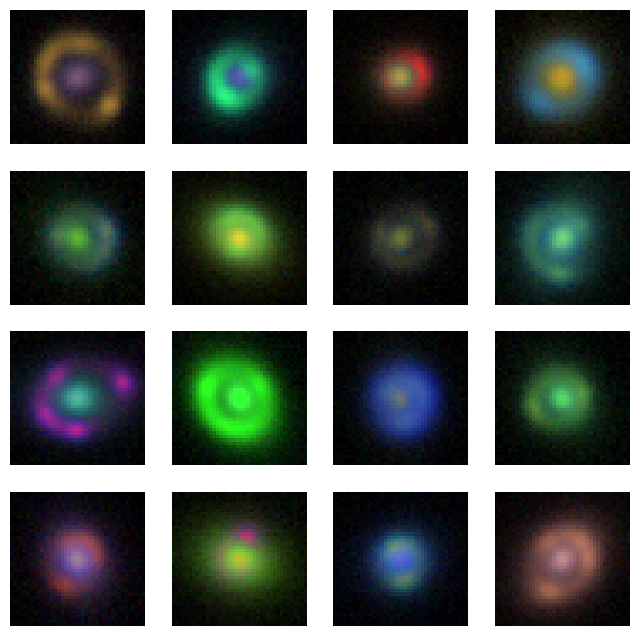

In [5]:
# Visualize target data
visualize_data(target_data)

In [6]:
# Define and initialize model
class NeuralNetwork(nn.Module):
    def __init__(self, npix):
        super(NeuralNetwork, self).__init__()
        self.feature = nn.Sequential()
        self.feature.add_module('f_conv1', nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu1', nn.ReLU(True))
        self.feature.add_module('f_bn1', nn.BatchNorm2d(8))
        self.feature.add_module('f_pool1', nn.MaxPool2d(kernel_size=2, stride=2))
        self.feature.add_module('f_conv2', nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu2', nn.ReLU(True))
        self.feature.add_module('f_bn2', nn.BatchNorm2d(16))
        self.feature.add_module('f_pool2', nn.MaxPool2d(kernel_size=2, stride=2))
        self.feature.add_module('f_conv3', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu3', nn.ReLU(True))
        self.feature.add_module('f_bn3', nn.BatchNorm2d(32))
        self.feature.add_module('f_pool3', nn.MaxPool2d(kernel_size=2, stride=2))

        self.regressor = nn.Sequential()
        self.regressor.add_module('r_fc1', nn.Linear(in_features=32*5*5, out_features=128))
        self.regressor.add_module('r_relu1', nn.ReLU(True))
        self.regressor.add_module('r_fc3', nn.Linear(in_features=128, out_features=2))

        self.npix = npix

    def forward(self, x):
        x = x.view(-1, 3, self.npix, self.npix)

        features = self.feature(x)
        features = features.view(-1, 32*5*5)
        estimate = self.regressor(features)
        estimate = F.relu(estimate)
        estimate = estimate.view(-1, 2)

        return estimate, features


    def get_feature(self, x):
        x = x.view(-1, 3, self.npix, self.npix)
        features = self.feature(x)
        features = features.view(-1, 32*5*5)
        return features

In [7]:
def loss_bnll(mean, variance, truth, beta, epsilon = 1e-7):  # beta=0.5):
    """Compute beta-NLL loss

    :param mean: Predicted mean of shape B x D
    :param variance: Predicted variance of shape B x D
    :param truth: truth of shape B x D
    :param beta: Parameter from range [0, 1] controlling relative
        weighting between data points, where `0` corresponds to
        high weight on low error points and `1` to an equal weighting.
    :returns: Loss per batch element of shape B
    """
    variance = variance + epsilon
    loss = 0.5 * ((truth - mean) ** 2 / variance + variance.log())
    if beta > 0:
        loss = loss * (variance.detach() ** beta)
    return loss.sum(axis=-1) / len(mean)

In [8]:
# Define training loop
def train_loop(source_dataloader, 
               target_dataloader, 
               model, 
               regressor_loss_fn,
               da_loss,
               optimizer,
               n_epoch,
               epoch,
               init_wt_da,
               final_wt_da,
               beta_init,
               beta_final):
               # init_wt_mve,
               # final_wt_mve):
    """
    Trains the Neural Network on Source/Target Domains with the following loss:
        Loss = Source Regression Loss + 1.4 * DA MMD Loss
    
    source_dataloader: DataLoader for the source domain data.
	target_dataloader: DataLoader for the target domain data.
	model: The neural network model to be trained.
	regressor_loss_fn: Loss function for the regression task (e.g., MSELoss).
	da_loss: Loss function for domain adaptation (e.g., MMD loss).
	optimizer: Optimizer for the model parameters.
	n_epoch: Total number of epochs for training.
	epoch: Current epoch number.
    """

    domain_error = 0
    domain_classifier_accuracy = 0
    estimator_error = 0
    mve_error = 0
    score_list = np.array([])

    # Iteration length is shorter of the two datasets
    len_dataloader = min(len(source_dataloader), len(target_dataloader))
    data_source_iter = iter(source_dataloader)
    data_target_iter = iter(target_dataloader)

    # Iterate over the two datasets
    i = 0
    while i < len_dataloader:

        # Time-varying hyperparameter, p 0 -> infty, alpha 0 -> 1
        p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader # UNUSED
        alpha = 2. / (1. + np.exp(-10 * p)) - 1 # UNUSED

        # Source Training

        # Load a batch of source data, move to GPU
        data_source = next(data_source_iter)
        X, y = data_source
        X = X.float()
        X = X.cuda()
        y = y.cuda()

        # Zero model gradients and labels
        model.zero_grad()
        batch_size = len(y)

        domain_label = torch.zeros(batch_size)
        domain_label = domain_label.long()
        domain_label = domain_label.cuda()

        # Apply data to model and get predictions, embeddings, apply gradients
        estimate_output, domain_output_source = model(X)
        mean = estimate_output[:, 0]
        variance = estimate_output[:, 1]

        # print(y.shape)
        # print(mean.shape)
        # Calculate source regression loss based on predictions
        estimate_loss = regressor_loss_fn(mean, y)

        
        # Target Training

        data_target = next(data_target_iter)
        X_target, _ = data_target
        X_target = X_target.float()
        X_target = X_target.cuda()

        batch_size = len(X_target)

        _, domain_output_target = model(X_target)

        # Calculate the DA Loss between source and target, MMD loss
        domain_loss = da_loss(domain_output_source, domain_output_target)
        beta_val = beta_init - (beta_init - beta_final) * (epoch / n_epoch)

        if ((epoch / n_epoch) > 0.5):
            beta_val = beta_final

        
        mve_loss = loss_bnll(mean.flatten(), variance.flatten(), y, beta = beta_val)
        
        # Hyperparameter of da_weight set to weight domain loss vs source loss
        # Perhaps this is where alpha was initially used
        da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / n_epoch))
        # mve_weight_power = (init_wt_mve - ((init_wt_mve - final_wt_mve) * (epoch / n_epoch)))
        # mve_weight = 10 ** (-mve_weight_power)

        # Calculate the R2 score of the predictions vs. labels
        score = r2_score(y.cpu().detach().numpy(), mean.cpu().detach().numpy())

        loss = mve_loss + domain_loss * da_weight 

        
        
        # Backpropagation, update optimizer lr
        loss.backward()
        optimizer.step()

        # Update values
        
        # Domain loss is the DA loss or MMD loss between embedding outputs
        domain_error += domain_loss.item()

        # Estimator loss is the source data loss on regression
        estimator_error += estimate_loss.item()

        mve_error += mve_loss.item()

        score_list = np.append(score_list, score)

        i += 1

    # Calculate average scores/errors of batches for this epoch
    score = np.mean(score_list)
    domain_error = domain_error / (len_dataloader)
    estimator_error /= len_dataloader
    mve_error /= len_dataloader

    return [domain_error, estimator_error, mve_error, score]

In [9]:
def test_loop(source_dataloader, 
              target_dataloader, 
              model, 
              regressor_loss_fn, 
              da_loss, 
              n_epoch, 
              epoch,
              beta_init,
              beta_final):
    """
    Tests the model accuracy.
    
    source_dataloader: DataLoader for the source domain data.
	target_dataloader: DataLoader for the target domain data.
	model: The neural network model to be trained.
	regressor_loss_fn: Loss function for the regression task (e.g., MSELoss).
	da_loss: Loss function for domain adaptation (e.g., MMD loss). UNUSED
	n_epoch: Total number of epochs for training.
	epoch: Current epoch number.
    """

    
    # Evaluating without gradient computation in bg for validation
    with torch.no_grad():
        
        len_dataloader = min(len(source_dataloader), len(target_dataloader))
        data_source_iter = iter(source_dataloader)
        data_target_iter = iter(target_dataloader)

        
        domain_classifier_error = 0
        domain_classifier_accuracy = 0
        estimator_error = 0
        estimator_error_target = 0
        mve_error = 0
        mve_error_target = 0
        score_list = np.array([])
        score_list_target = np.array([])

        i = 0
        while i < len_dataloader:

            p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
            alpha = 2. / (1. + np.exp(-10 * p)) - 1

            # Source Testing

            data_source = next(data_source_iter)
            X, y = data_source
            X = X.float()
            X = X.cuda()
            y = y.cuda()

            batch_size = len(y)

            estimate_output, domain_output = model(X)
            source_mean = estimate_output[:, 0]
            source_variance = estimate_output[:, 1]
            beta_val = beta_init - (beta_init - beta_final) * (epoch / n_epoch)

            if ((epoch / n_epoch) > 0.5):
                beta_val = beta_final
            
            estimate_loss = regressor_loss_fn(source_mean, y)
            mve_loss = loss_bnll(source_mean.flatten(), source_variance.flatten(), y, beta = beta_val)

            # Target Testing

            data_target = next(data_target_iter)
            X_target, y_target = data_target
            X_target = X_target.float()
            X_target = X_target.cuda()
            y_target = y_target.cuda()

            batch_size = len(X_target)

            estimate_output_target, domain_output = model(X_target)
            target_mean = estimate_output_target[:, 0]
            target_variance = estimate_output_target[:, 1]
            
            estimate_loss_target = regressor_loss_fn(target_mean, y_target)
            mve_loss_target = loss_bnll(target_mean.flatten(), target_variance.flatten(), y_target, beta = beta_val)
            
            # Update values

            # Regression loss on validation testing
            estimator_error += estimate_loss.item()
            estimator_error_target += estimate_loss_target.item()

            # MVE loss on validation testing
            mve_error += mve_loss.item()
            mve_error_target += mve_loss_target.item()

            # R2 Scores on validation testing
            score = r2_score(y.cpu(), source_mean.cpu())
            score_list = np.append(score_list, score)
            score_target = r2_score(y_target.cpu(), target_mean.cpu())
            score_list_target = np.append(score_list_target, score_target)

            i += 1

        score = np.mean(score_list)
        score_target = np.mean(score_list_target)
        estimator_error /= len_dataloader
        estimator_error_target /= len_dataloader
        mve_error /= len_dataloader
        mve_error_target /= len_dataloader
        
    classifier_error = 1 # UNUSED, legacy
    return [classifier_error, estimator_error, estimator_error_target, score, score_target, mve_error, mve_error_target]

In [10]:
model = NeuralNetwork(npix=40).cuda()
learning_rate = 2e-5
epochs = 75
# Define loss functions and optimizer
regressor_loss_fn = nn.MSELoss().cuda()

# Try to adjust momentum -> see if that helps
# Try SGD, Adadelta, see if that helps
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
da_loss = MMD_loss()

source_labels = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
target_labels = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

In [11]:
mod_name = None#"models/mb_lenscolor_jul25_1700" #
stats = {'train_DA_loss':[],
             'train_regression_loss':[],
             'train_mve_loss':[],
             'train_r2_score':[],
             'val_source_regression_loss':[],
             'val_target_regression_loss':[],
             'val_source_r2_score':[],
             'val_target_r2_score':[],
             'val_source_mve_loss': [],
             'val_target_mve_loss': [],
            'epoch_no': 0}
if mod_name is not None:
    state = torch.load(mod_name)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    
    stat_file = Path(mod_name+'.json')
    if stat_file.is_file():
        stats = json.load(open(mod_name+'.json', 'r'))

Beginning Training...
Generating Isomap...


/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


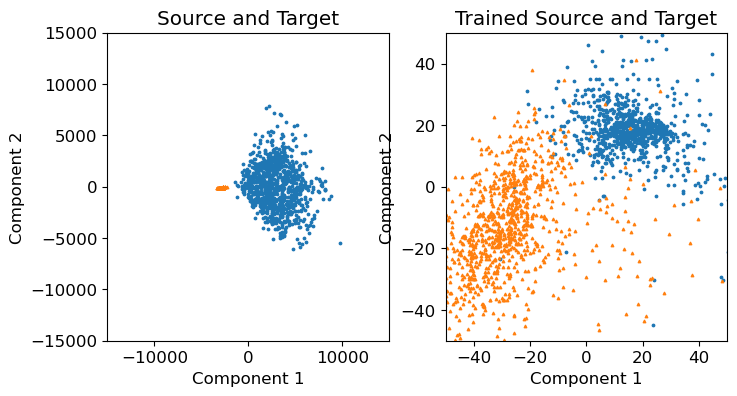

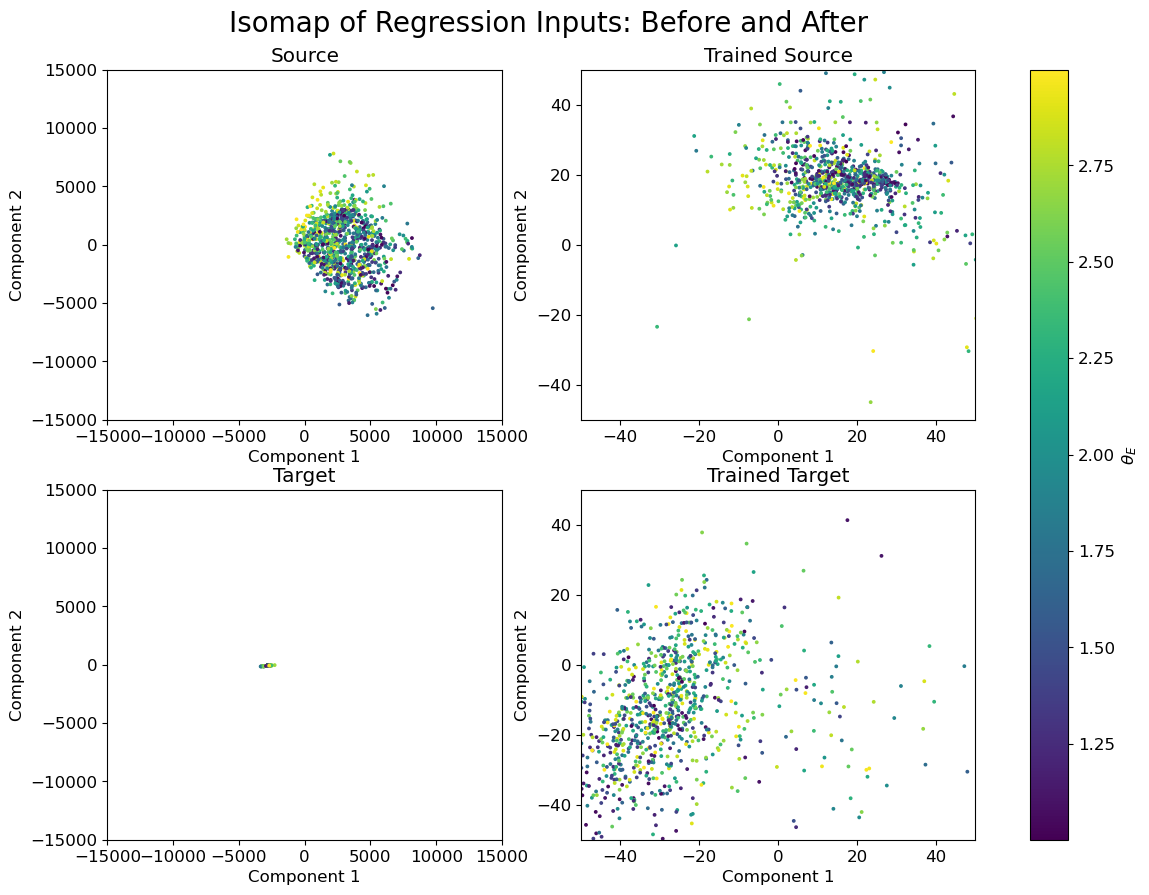


Epoch 0: 14.45s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3768
	Train Regression Loss: : 0.9861
	Train Mve Loss: : 0.4407
	Train R2 Score: : -2.1078
 Validation Statistics:
	Val Source Regression Loss: : 0.1734
	Val Target Regression Loss: : 0.2014
	Val Source R2 Score: : 0.4567
	Val Target R2 Score: : 0.3607
	Val Source Mve Loss: : -0.0714
	Val Target Mve Loss: : -0.0546
Saving Model... Done.

Epoch 1: 14.08s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2235
	Train Regression Loss: : 0.1097
	Train Mve Loss: : -0.0889
	Train R2 Score: : 0.6547
 Validation Statistics:
	Val Source Regression Loss: : 0.0825
	Val Target Regression Loss: : 0.1071
	Val Source R2 Score: : 0.7365
	Val Target R2 Score: : 0.6613
	Val Source Mve Loss: : -0.0819
	Val Target Mve Loss: : -0.0675
Saving Model... Done.

Epoch 2: 15.41s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1894
	Train Regression Loss: : 0.0702
	Train Mve 

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


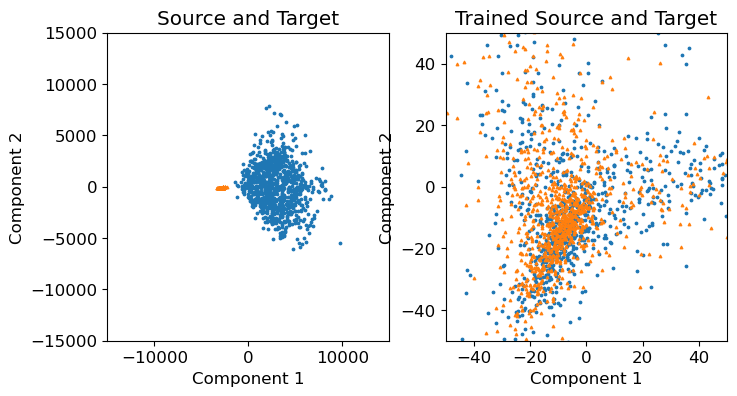

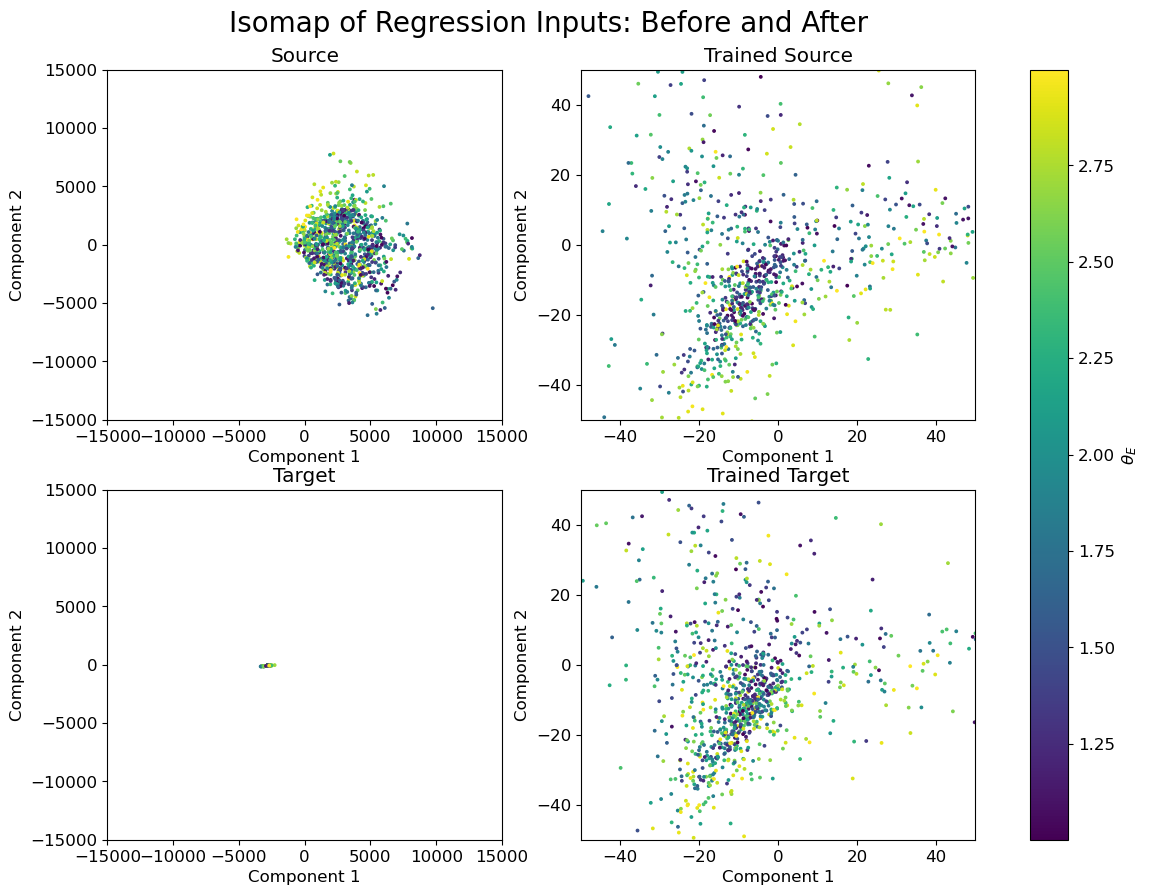

Saving Model... Done.

Epoch 5: 12.92s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1663
	Train Regression Loss: : 0.0497
	Train Mve Loss: : -0.0986
	Train R2 Score: : 0.8438
 Validation Statistics:
	Val Source Regression Loss: : 0.0535
	Val Target Regression Loss: : 0.0657
	Val Source R2 Score: : 0.8338
	Val Target R2 Score: : 0.7939
	Val Source Mve Loss: : -0.0888
	Val Target Mve Loss: : -0.0832
Saving Model... Done.

Epoch 6: 13.72s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1594
	Train Regression Loss: : 0.0473
	Train Mve Loss: : -0.1060
	Train R2 Score: : 0.8512
 Validation Statistics:
	Val Source Regression Loss: : 0.0517
	Val Target Regression Loss: : 0.0620
	Val Source R2 Score: : 0.8351
	Val Target R2 Score: : 0.8043
	Val Source Mve Loss: : -0.0723
	Val Target Mve Loss: : -0.0696
Saving Model... Done.

Epoch 7: 13.23s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1547
	Train Regression Loss

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


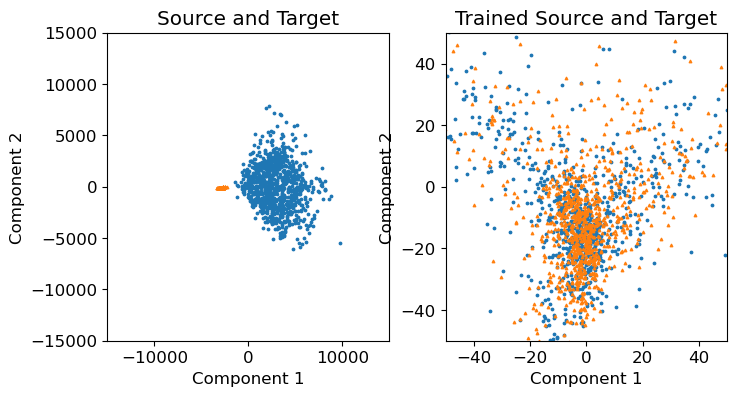

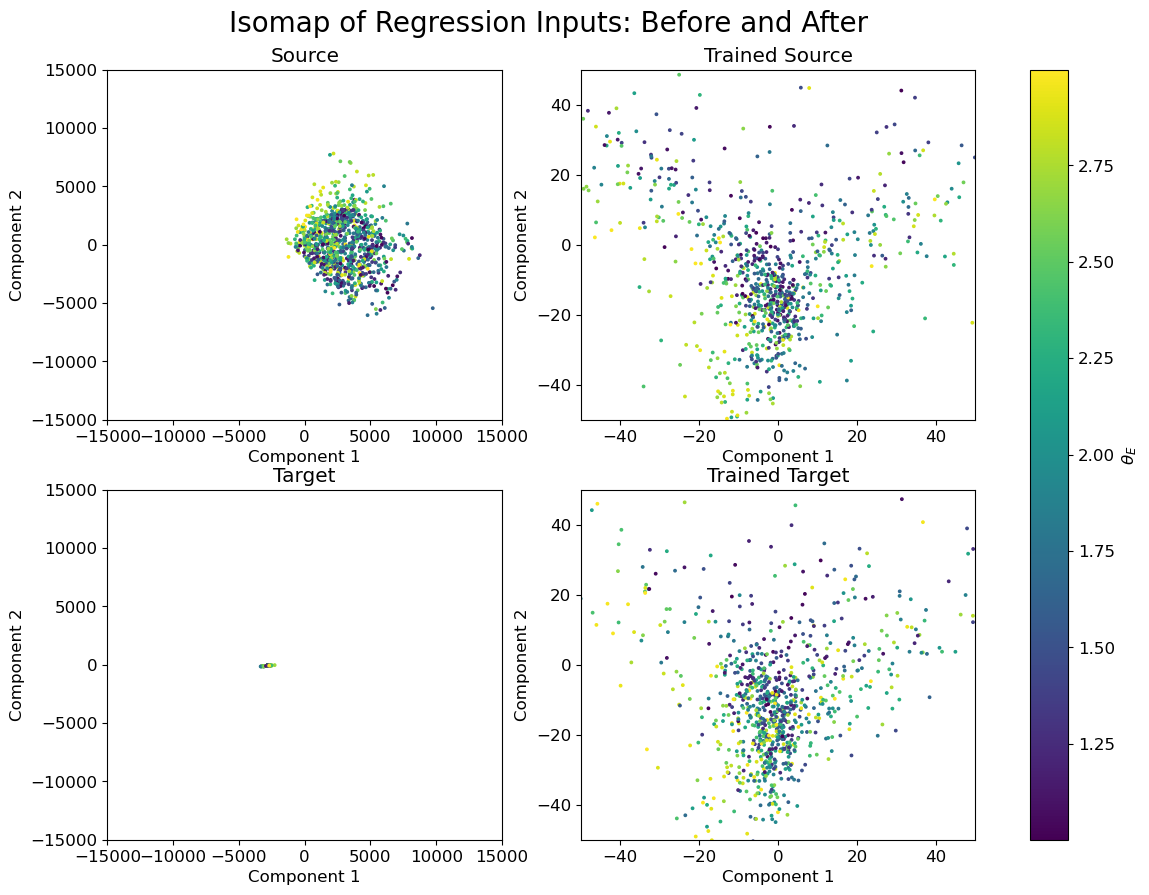

Saving Model... Done.

Epoch 10: 14.50s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1482
	Train Regression Loss: : 0.0424
	Train Mve Loss: : -0.1176
	Train R2 Score: : 0.8662
 Validation Statistics:
	Val Source Regression Loss: : 0.0458
	Val Target Regression Loss: : 0.0530
	Val Source R2 Score: : 0.8577
	Val Target R2 Score: : 0.8330
	Val Source Mve Loss: : -0.1522
	Val Target Mve Loss: : -0.1468
Saving Model... Done.

Epoch 11: 15.23s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1459
	Train Regression Loss: : 0.0419
	Train Mve Loss: : -0.1079
	Train R2 Score: : 0.8681
 Validation Statistics:
	Val Source Regression Loss: : 0.0445
	Val Target Regression Loss: : 0.0519
	Val Source R2 Score: : 0.8596
	Val Target R2 Score: : 0.8372
	Val Source Mve Loss: : -0.0789
	Val Target Mve Loss: : -0.0718
Saving Model... Done.

Epoch 12: 14.20s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1430
	Train Regression L

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


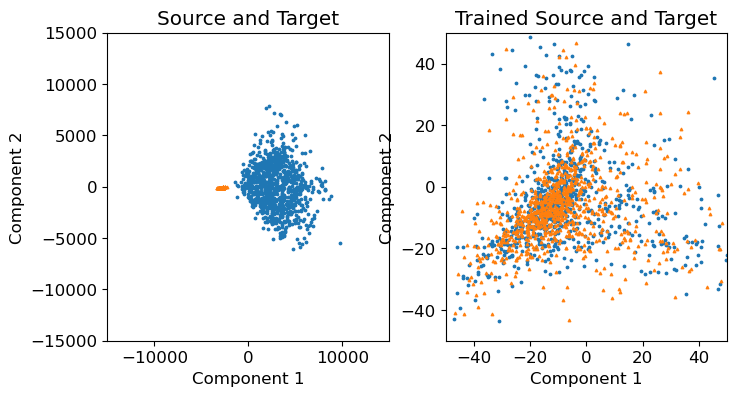

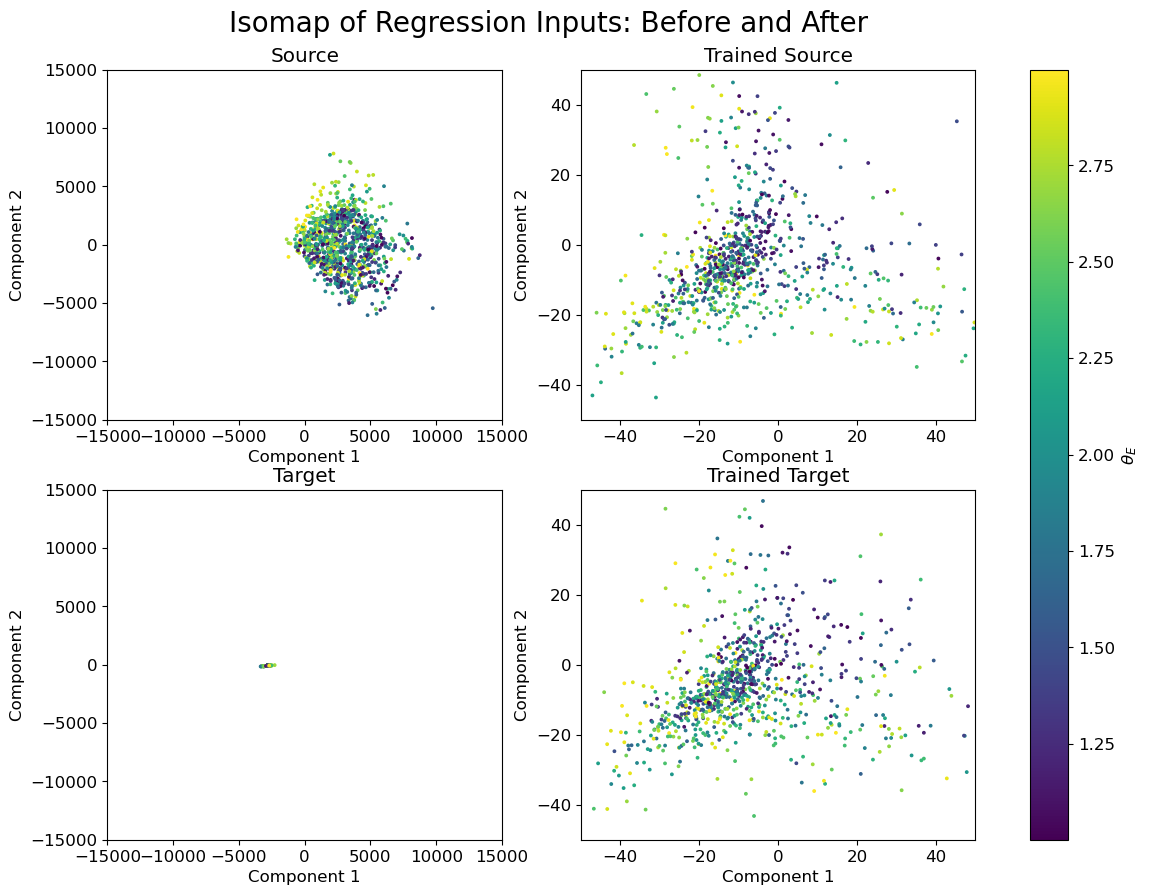

Saving Model... Done.

Epoch 15: 13.47s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1369
	Train Regression Loss: : 0.0345
	Train Mve Loss: : -0.0873
	Train R2 Score: : 0.8912
 Validation Statistics:
	Val Source Regression Loss: : 0.0362
	Val Target Regression Loss: : 0.0427
	Val Source R2 Score: : 0.8851
	Val Target R2 Score: : 0.8607
	Val Source Mve Loss: : -0.0728
	Val Target Mve Loss: : -0.0653
Saving Model... Done.

Epoch 16: 13.14s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1338
	Train Regression Loss: : 0.0327
	Train Mve Loss: : -0.0708
	Train R2 Score: : 0.8976
 Validation Statistics:
	Val Source Regression Loss: : 0.0357
	Val Target Regression Loss: : 0.0417
	Val Source R2 Score: : 0.8886
	Val Target R2 Score: : 0.8679
	Val Source Mve Loss: : -0.1412
	Val Target Mve Loss: : -0.1405
Saving Model... Done.

Epoch 17: 14.72s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1291
	Train Regression L

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


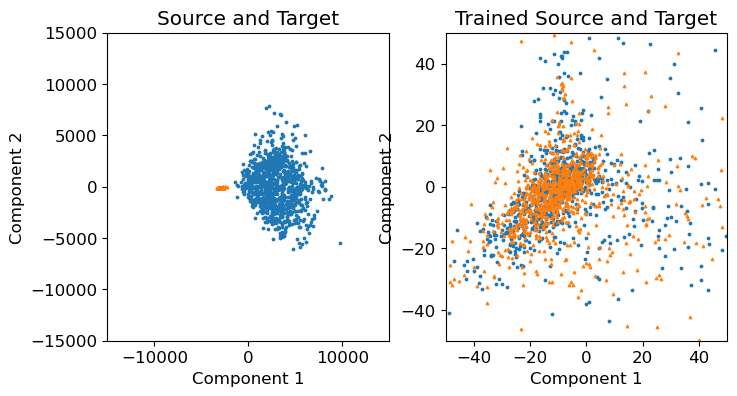

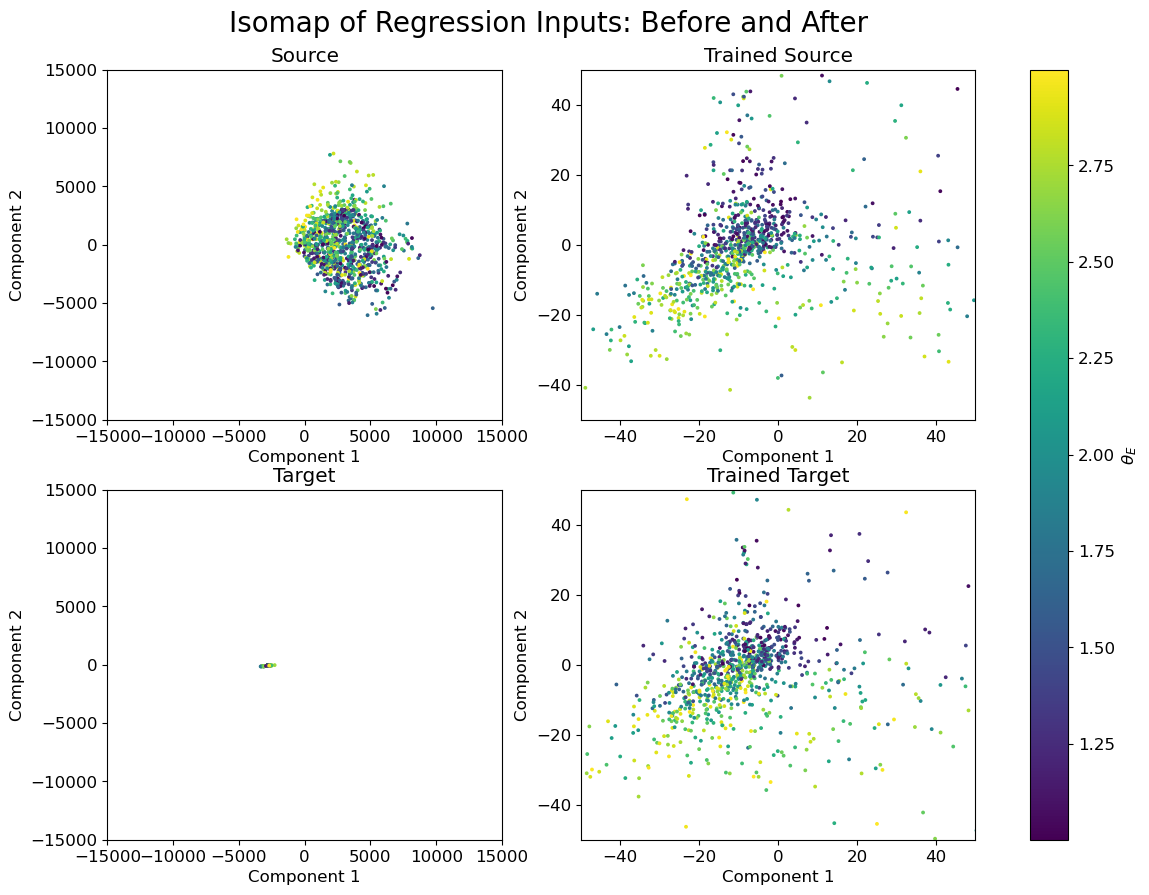

Saving Model... Done.

Epoch 20: 14.63s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1198
	Train Regression Loss: : 0.0279
	Train Mve Loss: : -0.0768
	Train R2 Score: : 0.9123
 Validation Statistics:
	Val Source Regression Loss: : 0.0304
	Val Target Regression Loss: : 0.0365
	Val Source R2 Score: : 0.9052
	Val Target R2 Score: : 0.8849
	Val Source Mve Loss: : -0.0250
	Val Target Mve Loss: : -0.0045

Epoch 21: 14.50s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1175
	Train Regression Loss: : 0.0273
	Train Mve Loss: : -0.0854
	Train R2 Score: : 0.9143
 Validation Statistics:
	Val Source Regression Loss: : 0.0300
	Val Target Regression Loss: : 0.0344
	Val Source R2 Score: : 0.9057
	Val Target R2 Score: : 0.8917
	Val Source Mve Loss: : -0.0602
	Val Target Mve Loss: : -0.0482
Saving Model... Done.

Epoch 22: 15.26s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1142
	Train Regression Loss: : 0.0259
	Train M

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


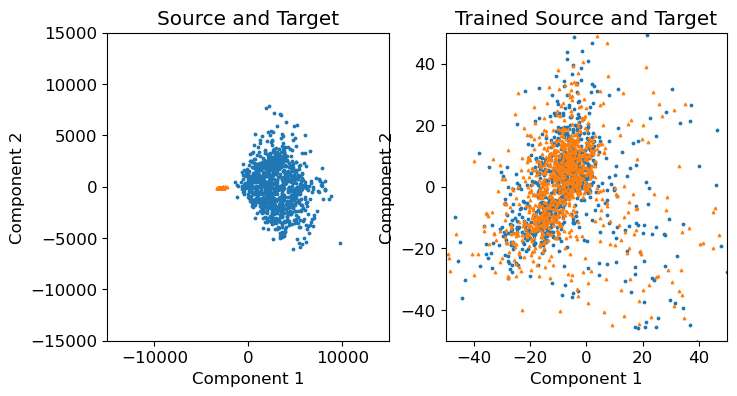

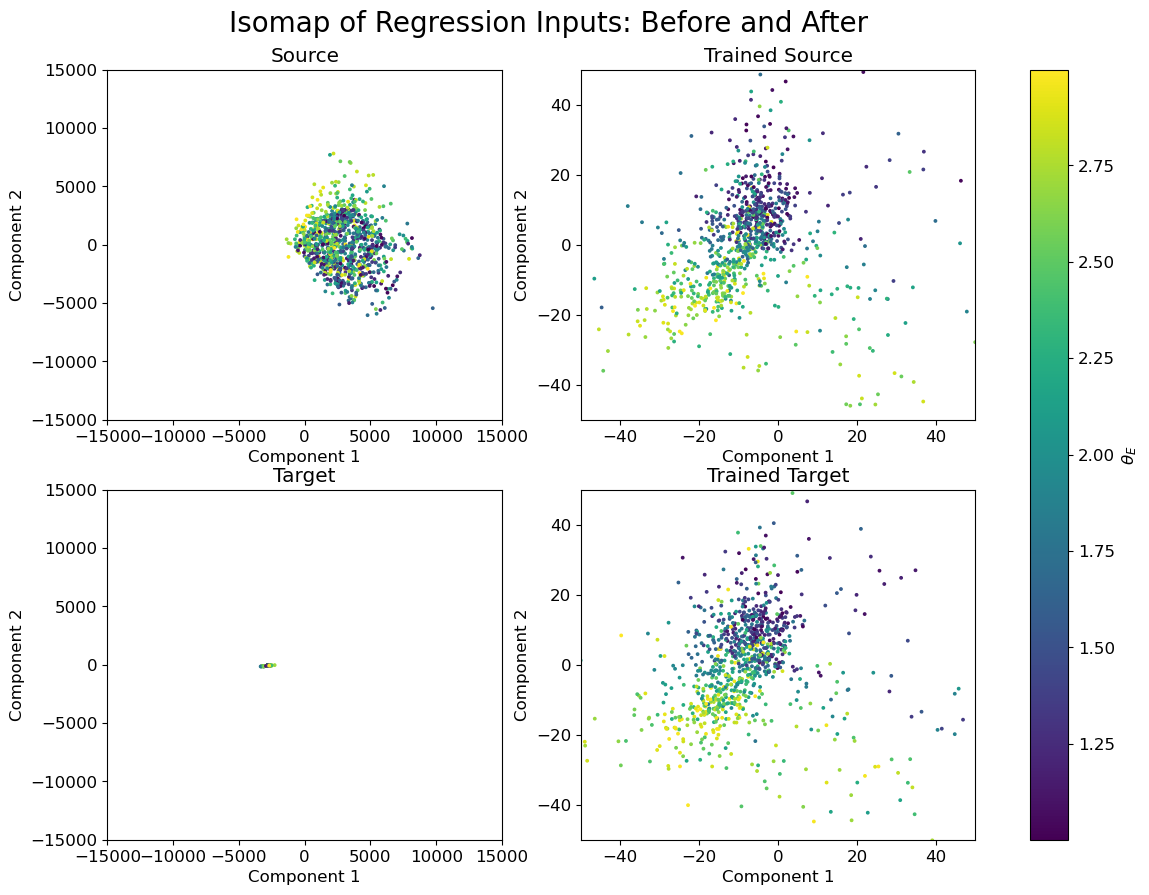

Saving Model... Done.

Epoch 25: 14.47s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1112
	Train Regression Loss: : 0.0234
	Train Mve Loss: : -0.1049
	Train R2 Score: : 0.9265
 Validation Statistics:
	Val Source Regression Loss: : 0.0269
	Val Target Regression Loss: : 0.0308
	Val Source R2 Score: : 0.9160
	Val Target R2 Score: : 0.9021
	Val Source Mve Loss: : -0.0643
	Val Target Mve Loss: : -0.0376
Saving Model... Done.

Epoch 26: 12.80s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1096
	Train Regression Loss: : 0.0227
	Train Mve Loss: : -0.0804
	Train R2 Score: : 0.9286
 Validation Statistics:
	Val Source Regression Loss: : 0.0284
	Val Target Regression Loss: : 0.0295
	Val Source R2 Score: : 0.9010
	Val Target R2 Score: : 0.9062
	Val Source Mve Loss: : -0.1129
	Val Target Mve Loss: : -0.0974
Saving Model... Done.

Epoch 27: 13.32s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1112
	Train Regression L

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


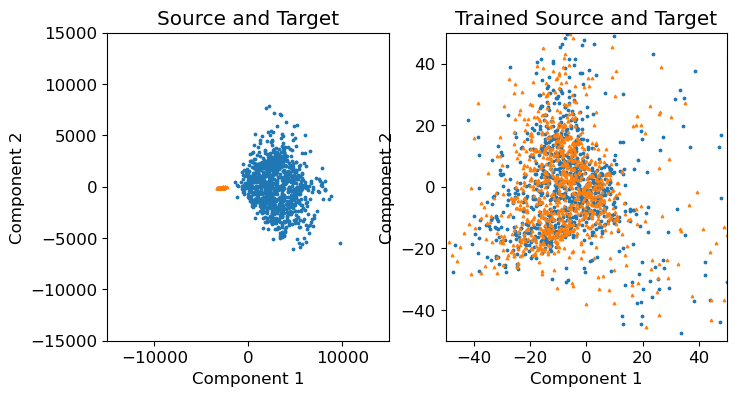

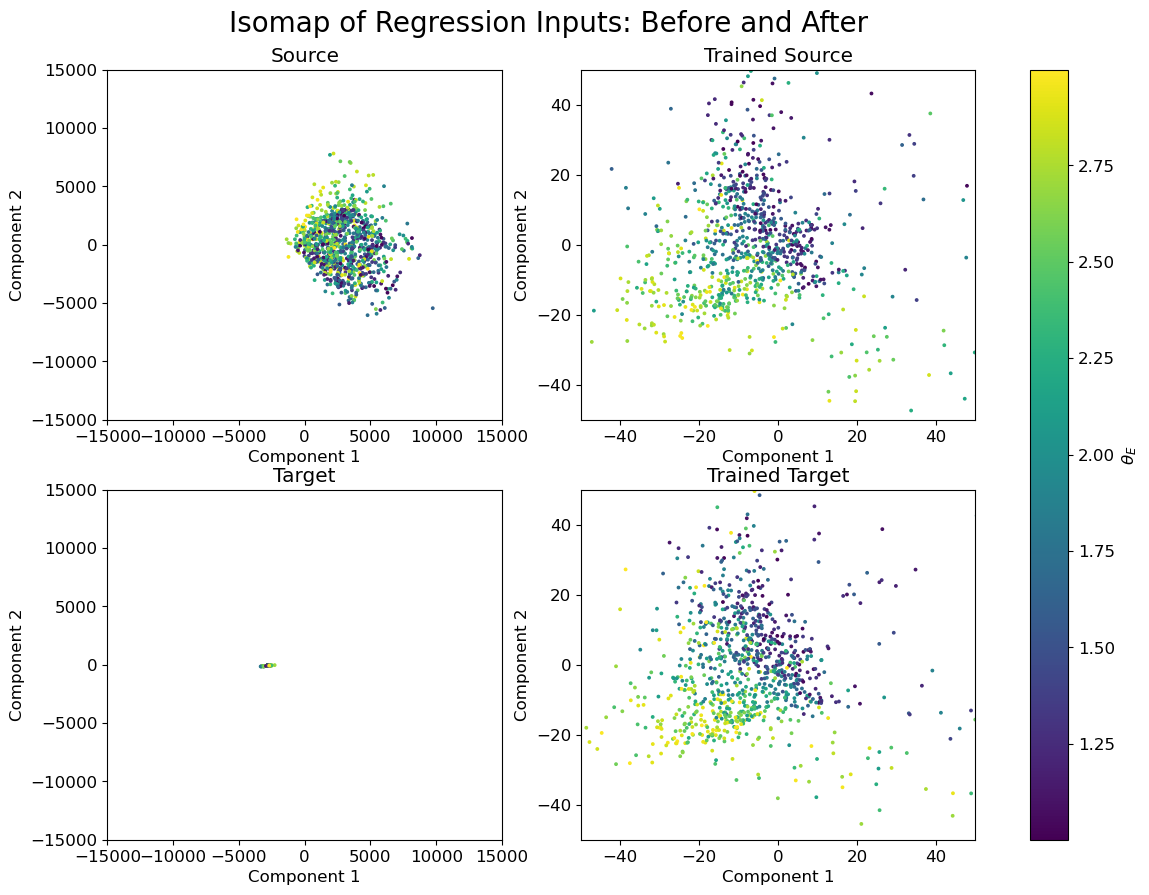

Saving Model... Done.

Epoch 30: 14.53s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1067
	Train Regression Loss: : 0.0207
	Train Mve Loss: : -0.0753
	Train R2 Score: : 0.9352
 Validation Statistics:
	Val Source Regression Loss: : 0.0229
	Val Target Regression Loss: : 0.0291
	Val Source R2 Score: : 0.9294
	Val Target R2 Score: : 0.9083
	Val Source Mve Loss: : -0.1217
	Val Target Mve Loss: : -0.1000

Epoch 31: 14.28s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1073
	Train Regression Loss: : 0.0209
	Train Mve Loss: : -0.0969
	Train R2 Score: : 0.9346
 Validation Statistics:
	Val Source Regression Loss: : 0.0239
	Val Target Regression Loss: : 0.0281
	Val Source R2 Score: : 0.9251
	Val Target R2 Score: : 0.9110
	Val Source Mve Loss: : -0.0811
	Val Target Mve Loss: : -0.0649

Epoch 32: 16.33s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1086
	Train Regression Loss: : 0.0209
	Train Mve Loss: : -0.0752
	Tr

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


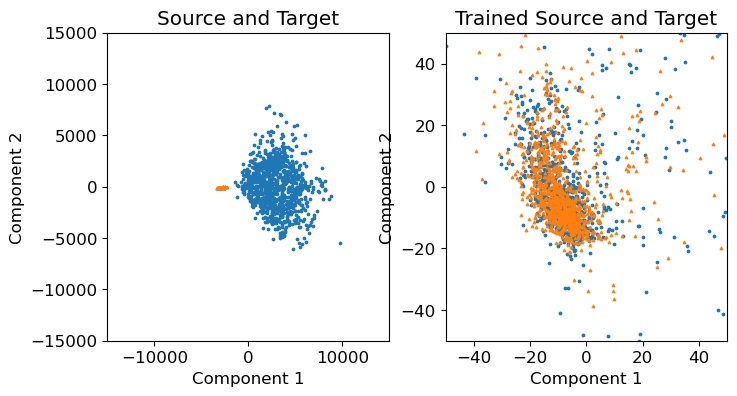

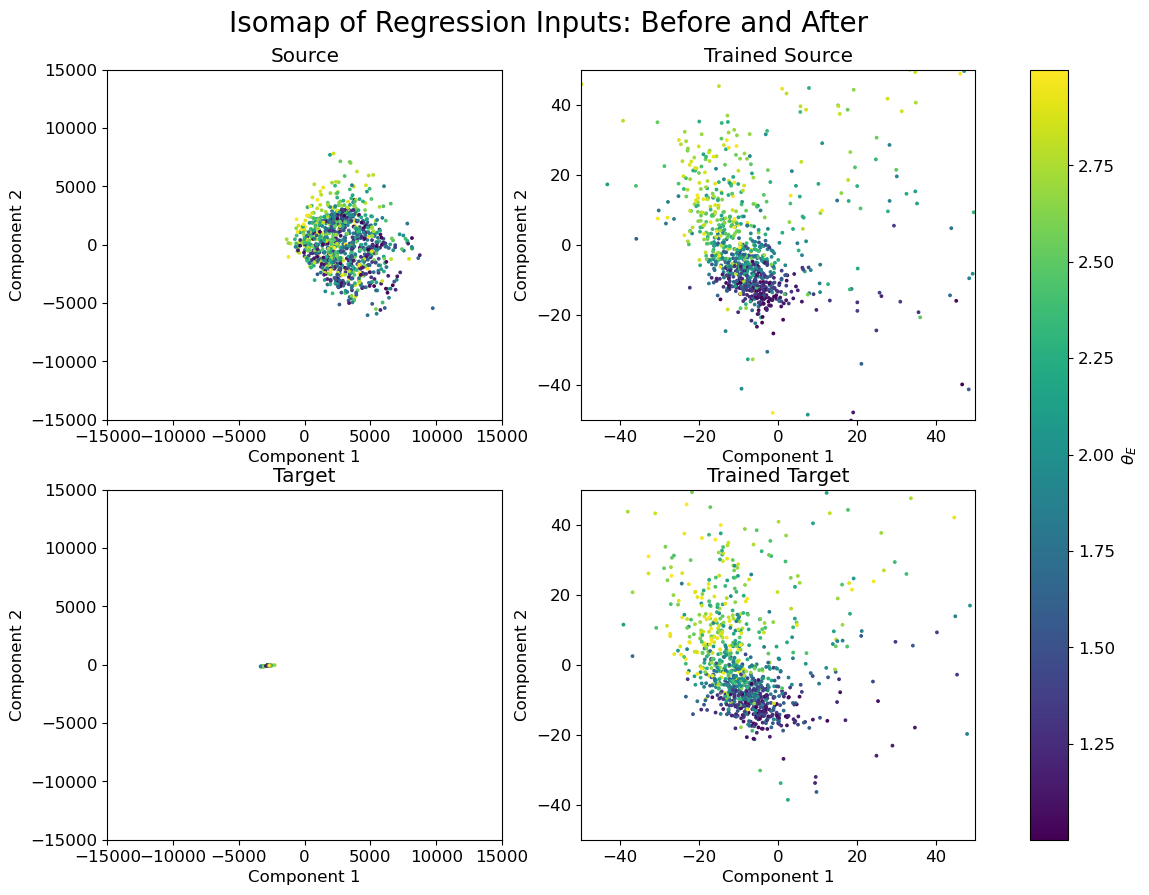


Epoch 35: 13.00s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1030
	Train Regression Loss: : 0.0198
	Train Mve Loss: : -0.1071
	Train R2 Score: : 0.9378
 Validation Statistics:
	Val Source Regression Loss: : 0.0220
	Val Target Regression Loss: : 0.0273
	Val Source R2 Score: : 0.9309
	Val Target R2 Score: : 0.9136
	Val Source Mve Loss: : -0.1289
	Val Target Mve Loss: : -0.1253

Epoch 36: 13.42s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1035
	Train Regression Loss: : 0.0192
	Train Mve Loss: : -0.0755
	Train R2 Score: : 0.9400
 Validation Statistics:
	Val Source Regression Loss: : 0.0214
	Val Target Regression Loss: : 0.0254
	Val Source R2 Score: : 0.9326
	Val Target R2 Score: : 0.9204
	Val Source Mve Loss: : 0.0192
	Val Target Mve Loss: : 0.0597
Saving Model... Done.

Epoch 37: 19.26s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1030
	Train Regression Loss: : 0.0187
	Train Mve Loss: : -0.0627
	Trai

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


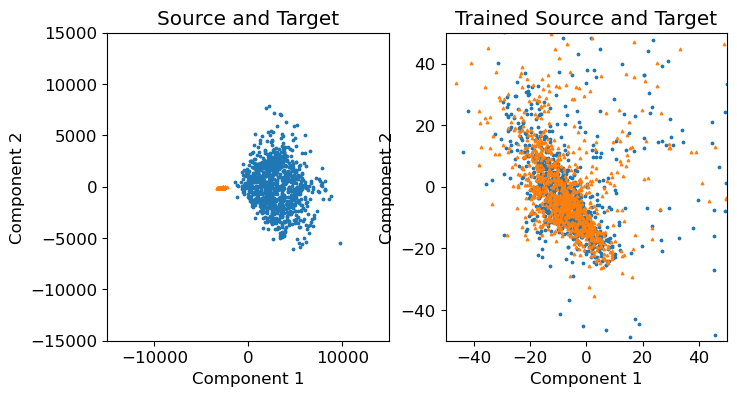

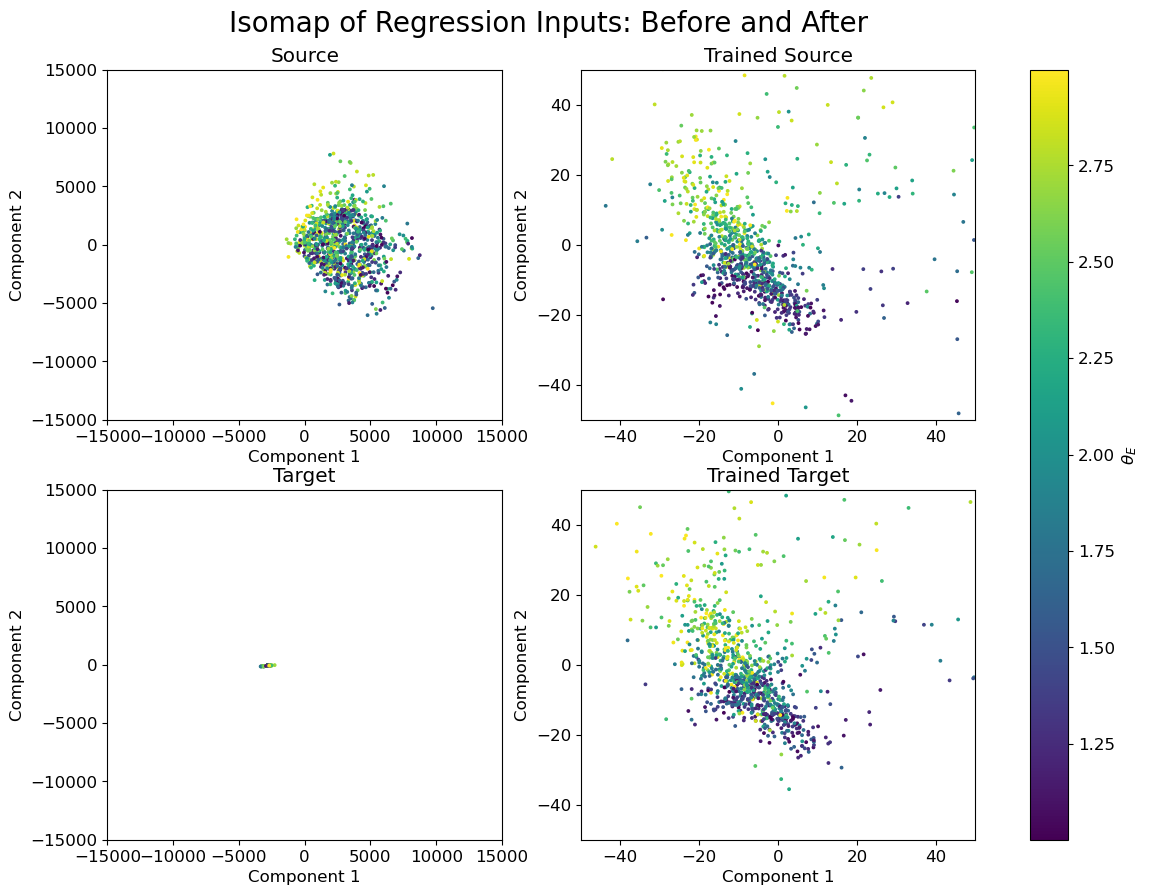


Epoch 40: 13.85s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1028
	Train Regression Loss: : 0.0199
	Train Mve Loss: : -0.0210
	Train R2 Score: : 0.9374
 Validation Statistics:
	Val Source Regression Loss: : 0.0213
	Val Target Regression Loss: : 0.0260
	Val Source R2 Score: : 0.9338
	Val Target R2 Score: : 0.9166
	Val Source Mve Loss: : 0.0062
	Val Target Mve Loss: : -0.0196

Epoch 41: 13.41s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1022
	Train Regression Loss: : 0.0192
	Train Mve Loss: : 0.1718
	Train R2 Score: : 0.9398
 Validation Statistics:
	Val Source Regression Loss: : 0.0197
	Val Target Regression Loss: : 0.0249
	Val Source R2 Score: : 0.9387
	Val Target R2 Score: : 0.9199
	Val Source Mve Loss: : 0.7045
	Val Target Mve Loss: : 1.0276

Epoch 42: 13.80s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1035
	Train Regression Loss: : 0.0192
	Train Mve Loss: : -0.0112
	Train R2 Score: : 0.9400
 Va

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


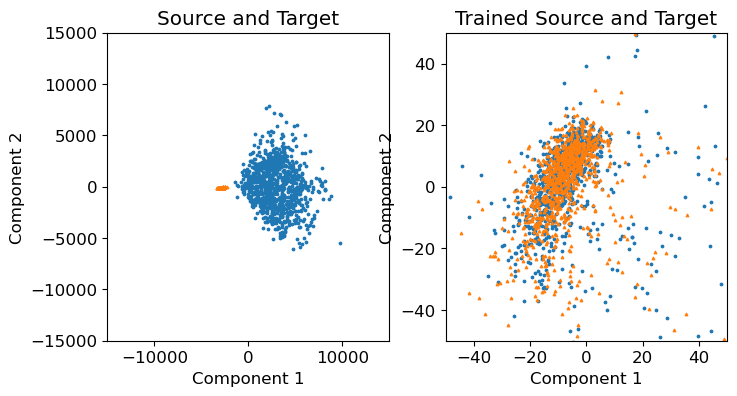

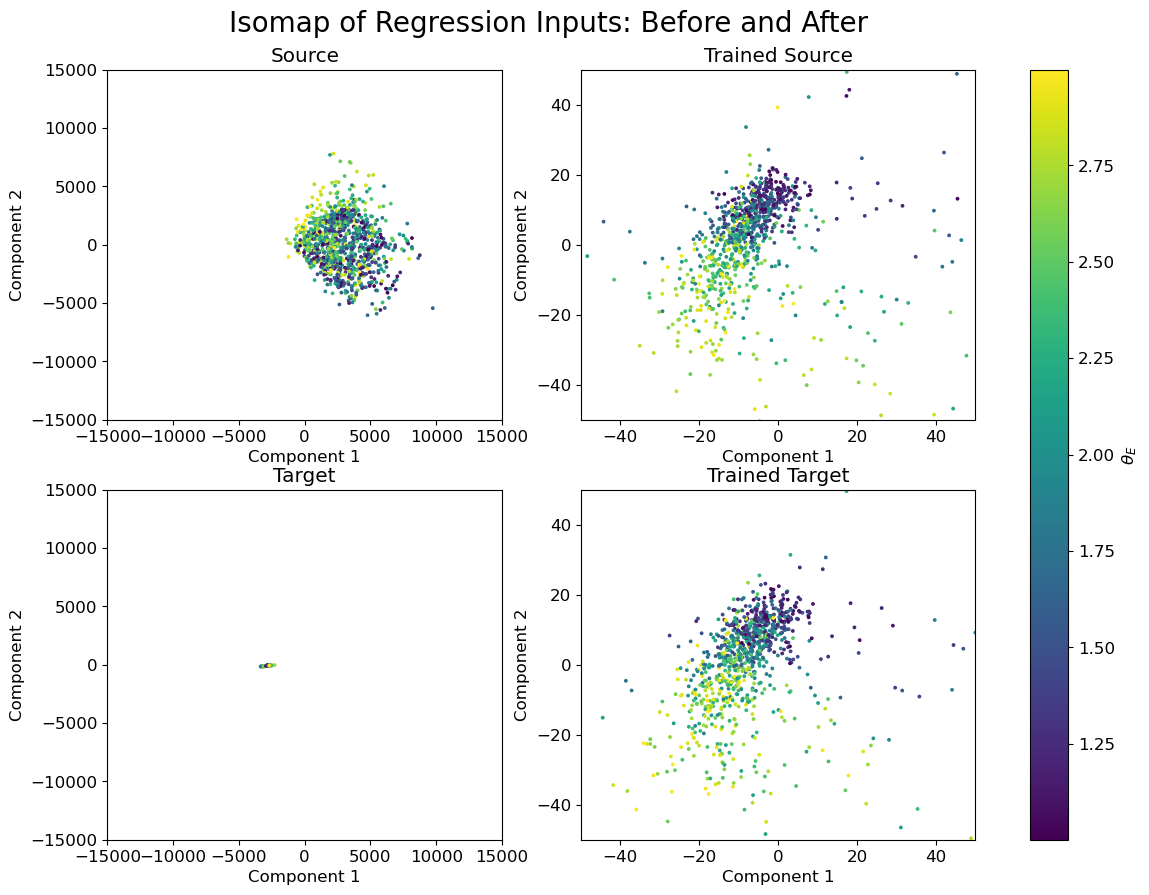


Epoch 45: 13.03s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1040
	Train Regression Loss: : 0.0197
	Train Mve Loss: : 0.0290
	Train R2 Score: : 0.9379
 Validation Statistics:
	Val Source Regression Loss: : 0.0233
	Val Target Regression Loss: : 0.0281
	Val Source R2 Score: : 0.9282
	Val Target R2 Score: : 0.9099
	Val Source Mve Loss: : 0.0268
	Val Target Mve Loss: : 0.0196

Epoch 46: 13.47s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1026
	Train Regression Loss: : 0.0190
	Train Mve Loss: : -0.0797
	Train R2 Score: : 0.9400
 Validation Statistics:
	Val Source Regression Loss: : 0.0228
	Val Target Regression Loss: : 0.0282
	Val Source R2 Score: : 0.9302
	Val Target R2 Score: : 0.9090
	Val Source Mve Loss: : -0.0477
	Val Target Mve Loss: : -0.0557

Epoch 47: 10.38s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1028
	Train Regression Loss: : 0.0184
	Train Mve Loss: : -0.0127
	Train R2 Score: : 0.9419
 V

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


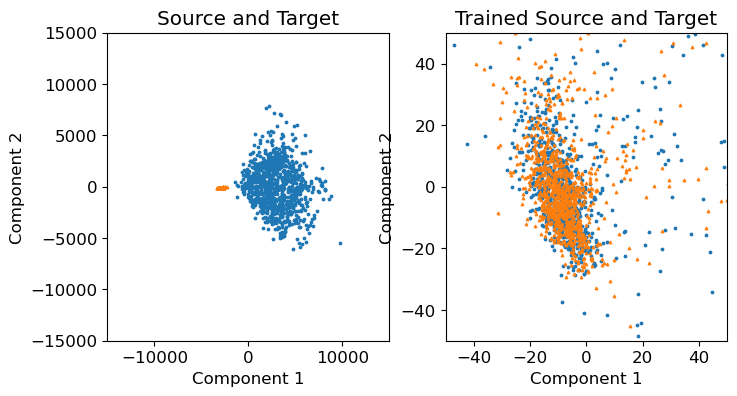

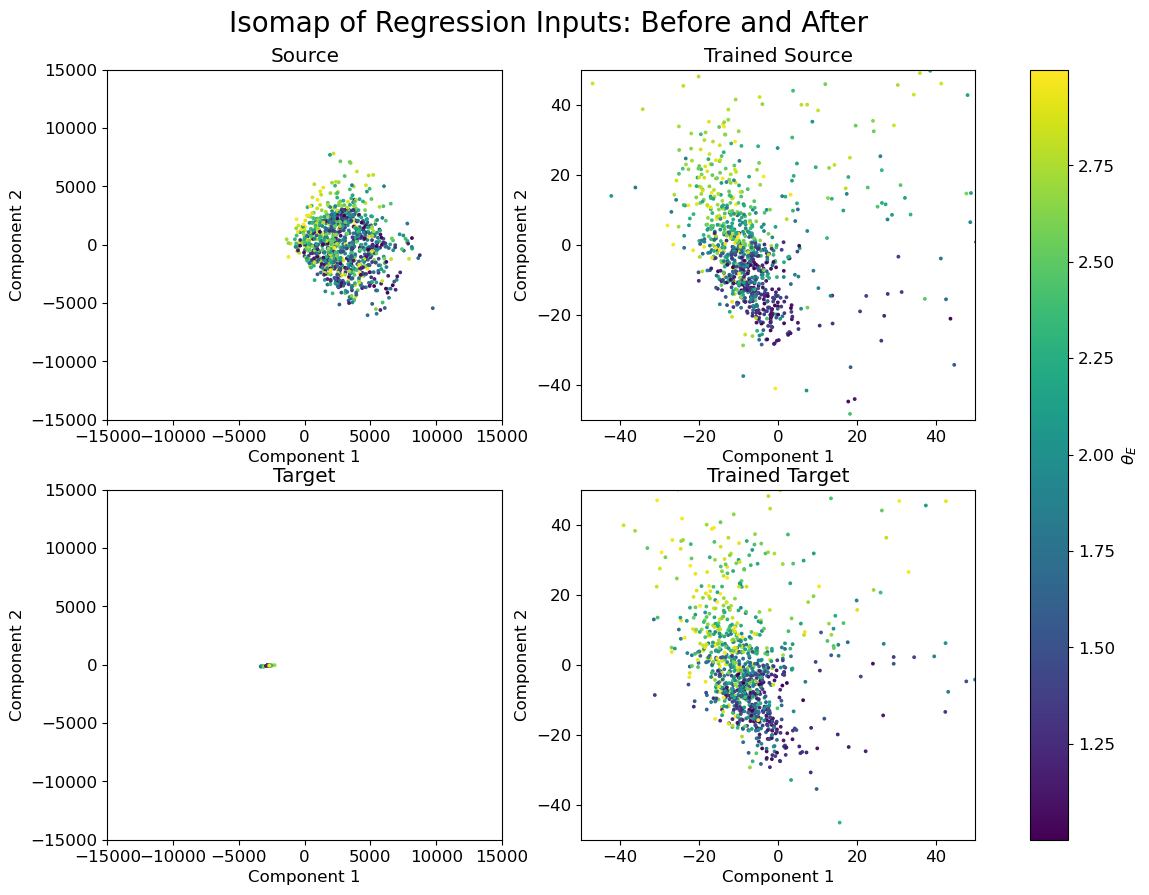


Epoch 50: 11.70s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1021
	Train Regression Loss: : 0.0175
	Train Mve Loss: : 0.0248
	Train R2 Score: : 0.9453
 Validation Statistics:
	Val Source Regression Loss: : 0.0184
	Val Target Regression Loss: : 0.0223
	Val Source R2 Score: : 0.9428
	Val Target R2 Score: : 0.9292
	Val Source Mve Loss: : -0.0439
	Val Target Mve Loss: : 0.0828
Saving Model... Done.

Epoch 51: 11.61s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1039
	Train Regression Loss: : 0.0185
	Train Mve Loss: : 0.0482
	Train R2 Score: : 0.9418
 Validation Statistics:
	Val Source Regression Loss: : 0.0256
	Val Target Regression Loss: : 0.0308
	Val Source R2 Score: : 0.9200
	Val Target R2 Score: : 0.9019
	Val Source Mve Loss: : 0.2783
	Val Target Mve Loss: : 0.4643

Epoch 52: 11.71s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1036
	Train Regression Loss: : 0.0191
	Train Mve Loss: : 0.1707
	Train R2

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


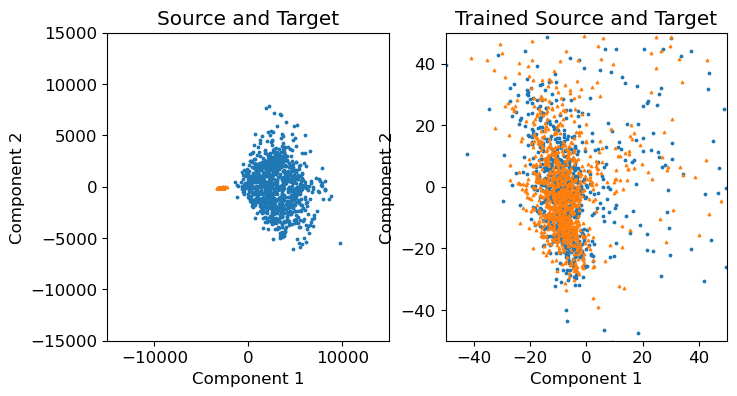

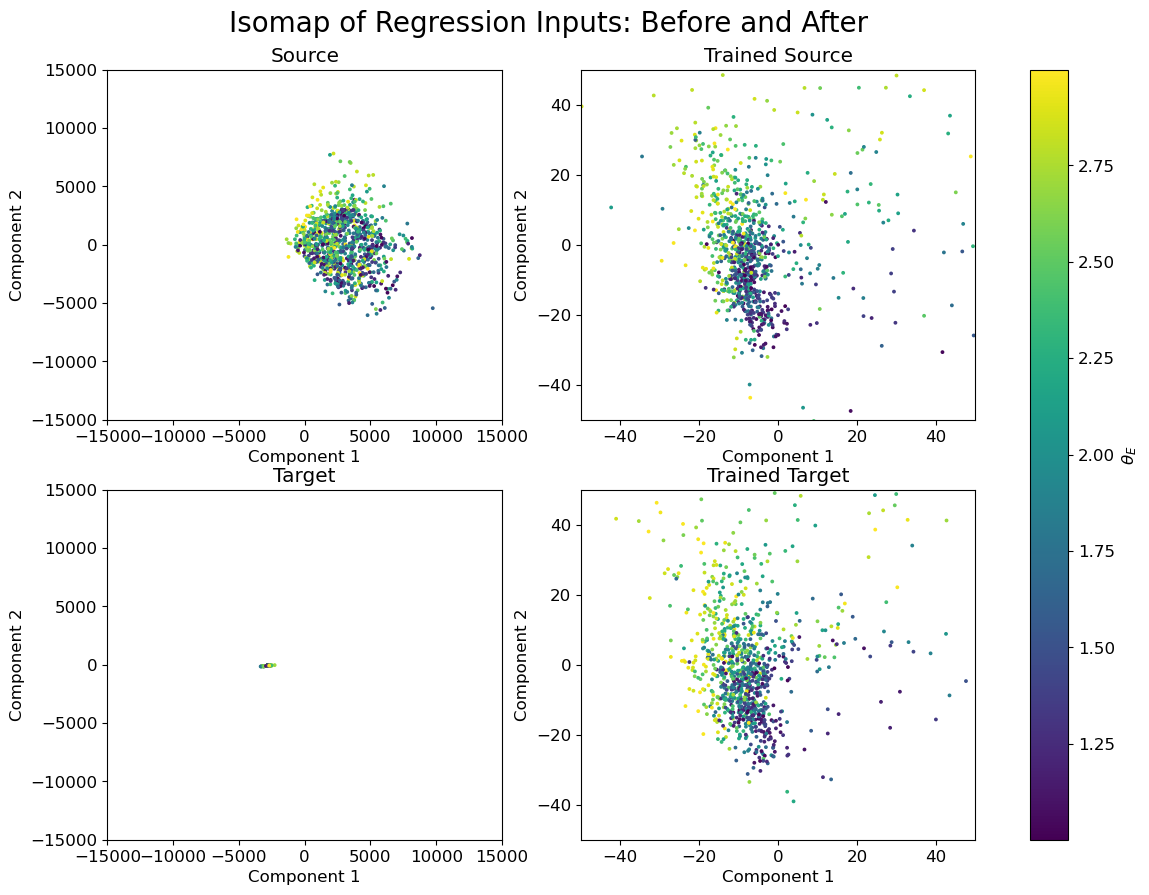

Saving Model... Done.

Epoch 55: 12.51s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1027
	Train Regression Loss: : 0.0168
	Train Mve Loss: : 0.2257
	Train R2 Score: : 0.9473
 Validation Statistics:
	Val Source Regression Loss: : 0.0209
	Val Target Regression Loss: : 0.0257
	Val Source R2 Score: : 0.9350
	Val Target R2 Score: : 0.9195
	Val Source Mve Loss: : 0.2624
	Val Target Mve Loss: : 0.1265

Epoch 56: 12.37s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1008
	Train Regression Loss: : 0.0188
	Train Mve Loss: : 0.0630
	Train R2 Score: : 0.9409
 Validation Statistics:
	Val Source Regression Loss: : 0.0212
	Val Target Regression Loss: : 0.0268
	Val Source R2 Score: : 0.9342
	Val Target R2 Score: : 0.9130
	Val Source Mve Loss: : 0.3183
	Val Target Mve Loss: : 0.2705

Epoch 57: 14.08s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1024
	Train Regression Loss: : 0.0178
	Train Mve Loss: : 0.1775
	Train R2 

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


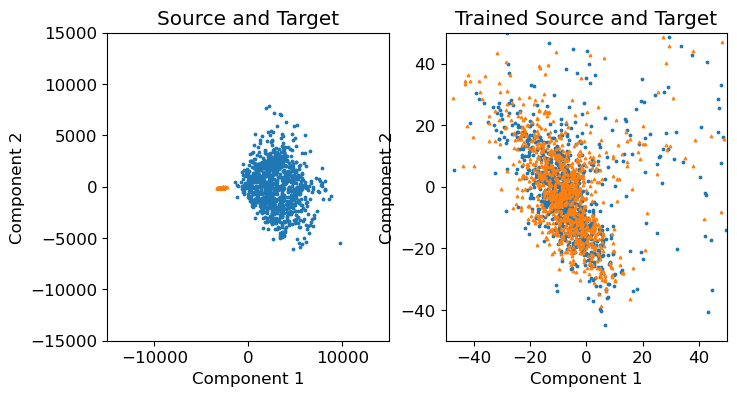

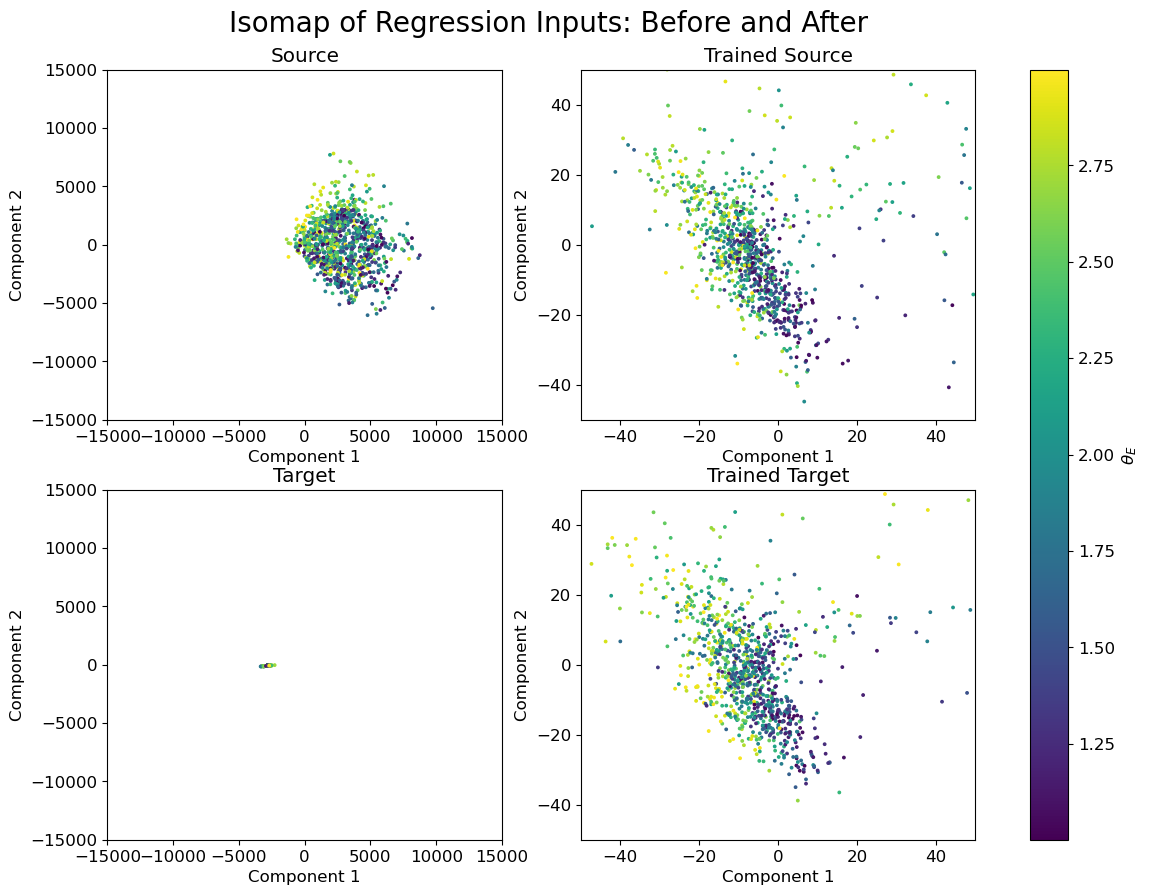

Saving Model... Done.

Epoch 60: 14.15s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1026
	Train Regression Loss: : 0.0161
	Train Mve Loss: : 0.0405
	Train R2 Score: : 0.9496
 Validation Statistics:
	Val Source Regression Loss: : 0.0174
	Val Target Regression Loss: : 0.0208
	Val Source R2 Score: : 0.9466
	Val Target R2 Score: : 0.9335
	Val Source Mve Loss: : 0.5790
	Val Target Mve Loss: : 0.7602

Epoch 61: 14.01s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1048
	Train Regression Loss: : 0.0155
	Train Mve Loss: : 0.3608
	Train R2 Score: : 0.9514
 Validation Statistics:
	Val Source Regression Loss: : 0.0171
	Val Target Regression Loss: : 0.0196
	Val Source R2 Score: : 0.9463
	Val Target R2 Score: : 0.9366
	Val Source Mve Loss: : 0.7169
	Val Target Mve Loss: : 0.9098

Epoch 62: 13.37s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1051
	Train Regression Loss: : 0.0154
	Train Mve Loss: : 0.2504
	Train R2 

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


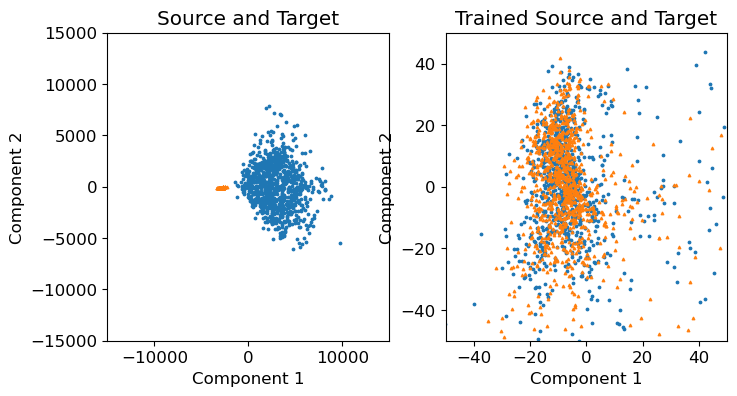

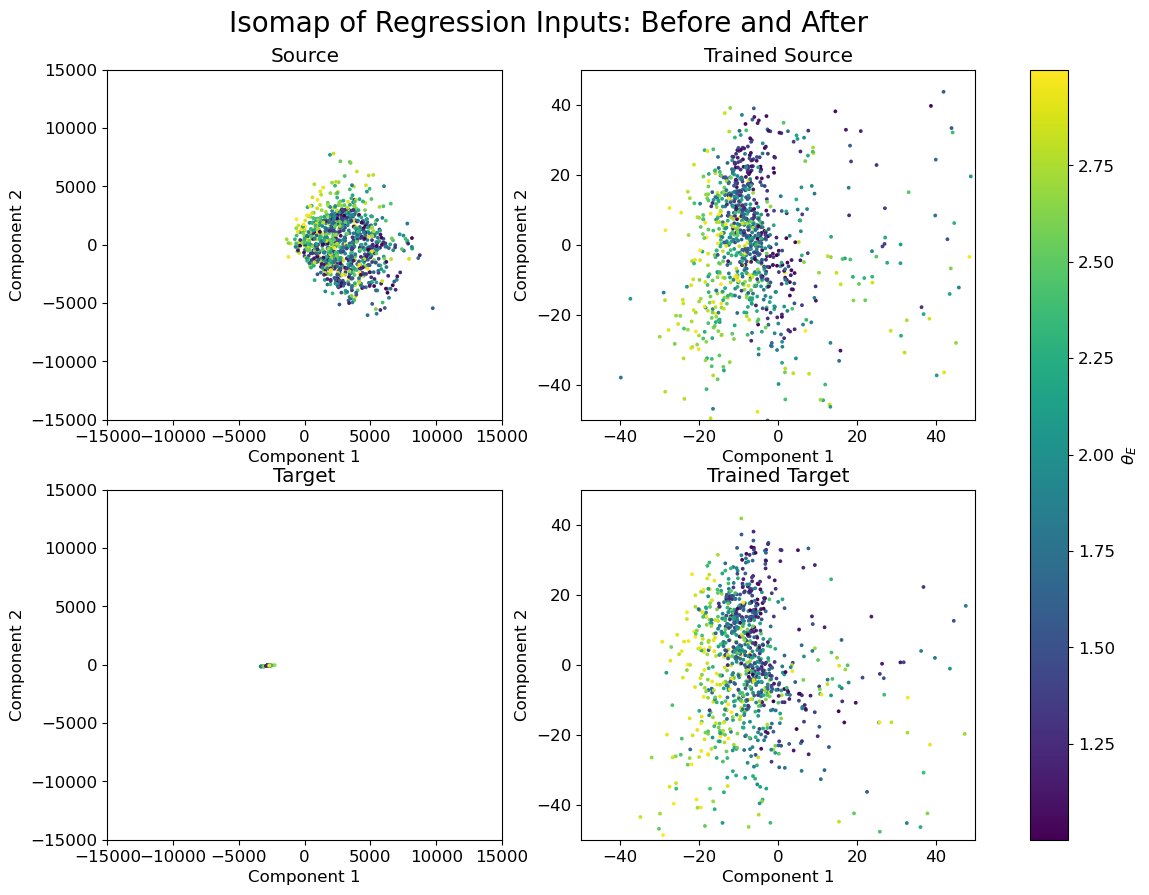


Epoch 65: 15.04s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1043
	Train Regression Loss: : 0.0153
	Train Mve Loss: : 0.0273
	Train R2 Score: : 0.9523
 Validation Statistics:
	Val Source Regression Loss: : 0.0183
	Val Target Regression Loss: : 0.0212
	Val Source R2 Score: : 0.9431
	Val Target R2 Score: : 0.9298
	Val Source Mve Loss: : -0.0670
	Val Target Mve Loss: : 0.0565

Epoch 66: 14.22s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1039
	Train Regression Loss: : 0.0169
	Train Mve Loss: : 0.0437
	Train R2 Score: : 0.9469
 Validation Statistics:
	Val Source Regression Loss: : 0.0191
	Val Target Regression Loss: : 0.0208
	Val Source R2 Score: : 0.9401
	Val Target R2 Score: : 0.9329
	Val Source Mve Loss: : 0.1279
	Val Target Mve Loss: : 0.0471

Epoch 67: 15.53s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1040
	Train Regression Loss: : 0.0174
	Train Mve Loss: : -0.0502
	Train R2 Score: : 0.9451
 Val

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


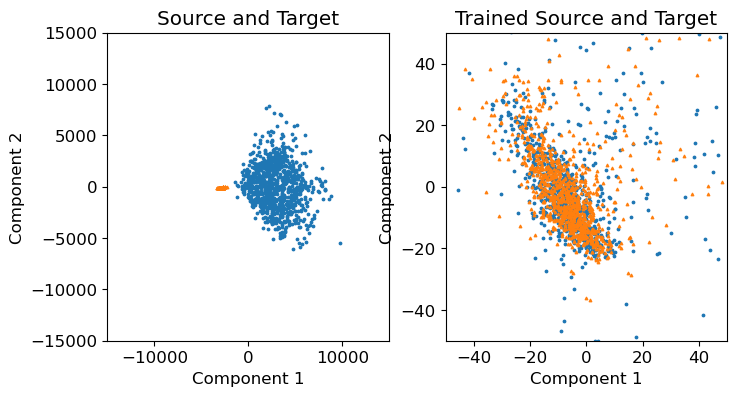

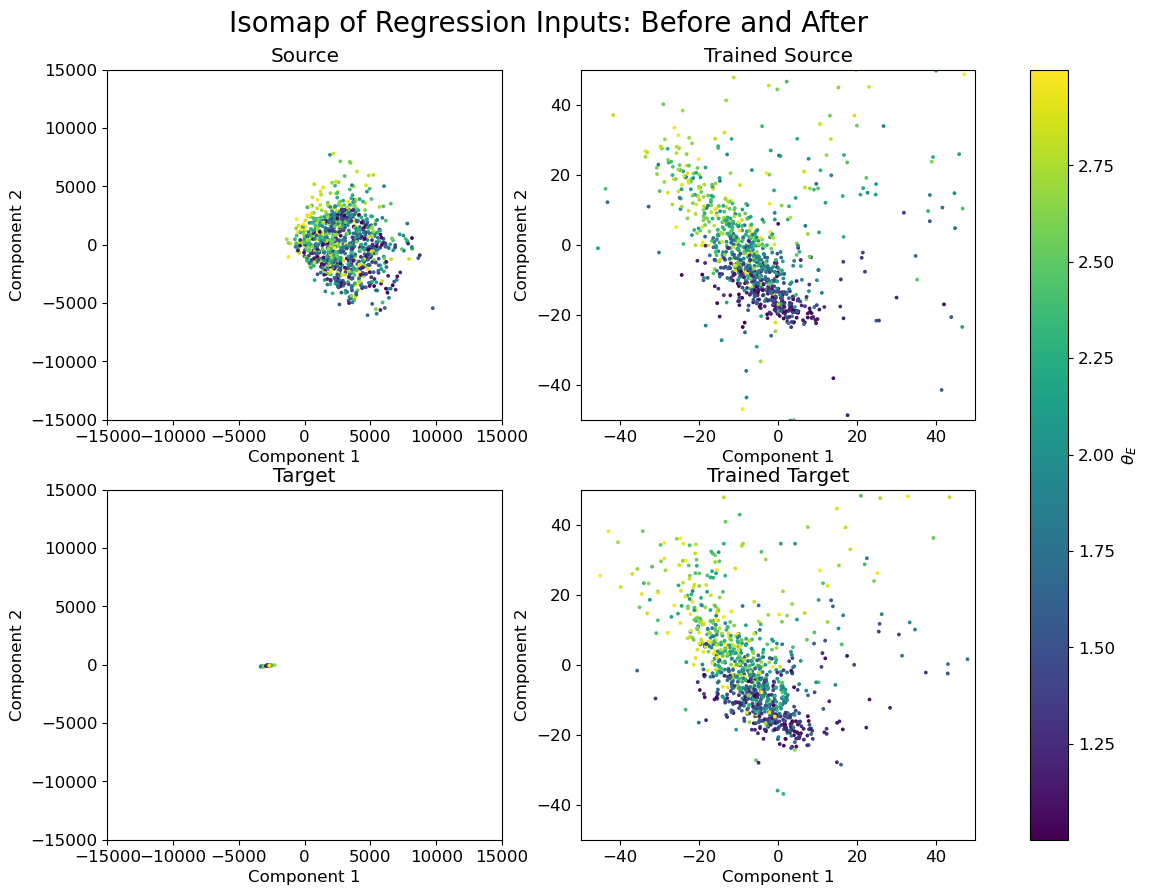


Epoch 70: 16.63s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1029
	Train Regression Loss: : 0.0157
	Train Mve Loss: : -0.0575
	Train R2 Score: : 0.9505
 Validation Statistics:
	Val Source Regression Loss: : 0.0171
	Val Target Regression Loss: : 0.0203
	Val Source R2 Score: : 0.9466
	Val Target R2 Score: : 0.9353
	Val Source Mve Loss: : -0.1535
	Val Target Mve Loss: : -0.1867

Epoch 71: 15.22s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1042
	Train Regression Loss: : 0.0159
	Train Mve Loss: : -0.0353
	Train R2 Score: : 0.9498
 Validation Statistics:
	Val Source Regression Loss: : 0.0182
	Val Target Regression Loss: : 0.0213
	Val Source R2 Score: : 0.9423
	Val Target R2 Score: : 0.9310
	Val Source Mve Loss: : 0.2746
	Val Target Mve Loss: : 0.6567

Epoch 72: 15.54s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1029
	Train Regression Loss: : 0.0160
	Train Mve Loss: : 0.1204
	Train R2 Score: : 0.9499
 V

In [11]:
print("Beginning Training...")
mod_name = "models/mb_mvebeta_75epoch_aug2_2000"
# Train
best_target_R2 = -1.0
for i in range(stats['epoch_no'], stats['epoch_no'] + epochs):
        if (i % 5 == 0):
            print("Generating Isomap...")
            source_iso, target_iso, trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, target_iso, trained_source_iso, trained_target_iso, source_labels, target_labels, mod_name, stats["epoch_no"], 15000, 50, save = True)
        if (len(stats['val_target_r2_score']) > 0) and (stats['val_target_r2_score'][-1] > best_target_R2):
            print("Saving Model...", end = ' ')
            state = {
                    'epoch': stats['epoch_no'],
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    }
            json.dump(stats, open(mod_name+'.json', 'w'))
            torch.save(state, mod_name)
            best_target_R2 = stats['val_target_r2_score'][-1]
            print("Done.")
            
        start_time = time.time()
        vals = train_loop(source_train_dataloader, target_train_dataloader, model,
                   regressor_loss_fn, da_loss, optimizer, epochs, i, init_wt_da = 1.4, final_wt_da = 1.0, beta_init = 1, beta_final = 0.6)
#                         init_wt_mve = 6, final_wt_mve = 2)

        vals_validate = test_loop(source_val_dataloader, target_val_dataloader,
                         model, regressor_loss_fn, da_loss, epochs, i, beta_init = 1, beta_final = 0.6)

        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_mve_loss'].append(vals[2])
        stats['train_r2_score'].append(vals[3])
        stats['val_source_regression_loss'].append(vals_validate[1])
        stats['val_target_regression_loss'].append(vals_validate[2])
        stats['val_source_r2_score'].append(vals_validate[3])
        stats['val_target_r2_score'].append(vals_validate[4])
        stats['val_source_mve_loss'].append(vals_validate[5])
        stats['val_target_mve_loss'].append(vals_validate[6])
        stats['epoch_no'] += 1

        
        print_epoch_scores(stats, i, time.time() - start_time)

In [12]:
state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
mod_name = "models/mb_mvebetaFinal_75epoch_aug2_2000"
torch.save(state, mod_name)
json.dump(stats, open(mod_name+'.json', 'w'))

In [12]:
mod_name = "models/mb_mvebeta_75epoch_aug2_2000"
model.load_state_dict(torch.load(mod_name)['state_dict'])
stats = json.load(open(mod_name+'.json', 'r'))

def generate_isomaps(source_data, target_data, model, n_neighbors = 5, n_components = 2, n_points = 1000):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    gc.collect()
    torch.cuda.empty_cache()
    
    isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    train_isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    
    sdata = source_data.reshape([-1, np.prod(source_data.shape[1:])])[:n_points]
    tdata = target_data.reshape([-1, np.prod(target_data.shape[1:])])[:n_points]
    catdata = np.concatenate((sdata, tdata), axis=0)
    print(catdata.shape)
    isomap = isomap.fit(catdata)
    
    with torch.no_grad():
        source_tensor = torch.FloatTensor(source_data[:n_points]).to(device)
        target_tensor = torch.FloatTensor(target_data[:n_points]).to(device)
        sfeat = model.get_feature(source_tensor).cpu().detach().numpy()
        tfeat = model.get_feature(target_tensor).cpu().detach().numpy()
        catfeat = np.concatenate((sfeat, tfeat), axis=0)
        
    train_isomap = train_isomap.fit(catfeat)
    trained_source_iso = train_isomap.transform(sfeat)
    trained_target_iso = train_isomap.transform(tfeat)
    
    del sfeat
    del tfeat
    
    source_iso = isomap.transform(sdata)
    target_iso = isomap.transform(tdata)

    return source_iso, target_iso, trained_source_iso, trained_target_iso


In [108]:
source_iso, target_iso, trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)

(2000, 6075)


def show_isomaps(source_iso, 
                 target_iso, 
                 trained_source_iso, 
                 trained_target_iso, 
                 source_labels,
                 target_labels,
                 mod_name, 
                 epoch_no,
                 pretrain_lim = 500,
                 posttrain_lim = 50,
                 save = False):
    
    fig0, axes = plt.subplots(1, 2, figsize=(8, 4))

    (ax1, ax2) = axes
    ax1.scatter(source_iso[:, 0], source_iso[:, 1], s=3, marker='o')
    ax1.scatter(target_iso[:, 0], target_iso[:, 1], s=3, marker='^')
    lval1 = pretrain_lim
    ax1.set_xlim(-lval1, lval1)
    ax1.set_ylim(-lval1, lval1)
    ax1.set_title('Source and Target')
    
    ax2.scatter(trained_source_iso[:, 0], trained_source_iso[:, 1], s=3, marker='o')
    ax2.scatter(trained_target_iso[:, 0], trained_target_iso[:, 1], s=3, marker='^')
    lval2 = posttrain_lim
    ax2.set_xlim(-lval2, lval2)
    ax2.set_ylim(-lval2, lval2)
    ax2.set_title('Trained Source and Target')
    
    ax1.set_xlabel('Component 1')
    ax1.set_ylabel('Component 2')
    ax2.set_xlabel('Component 1')
    ax2.set_ylabel('Component 2')
    
    if save:
        plt.savefig(mod_name + "_" + str(epoch_no) + "_compare.png", bbox_inches = 'tight', dpi = 400)
        
    plt.show()

    fig1, ax = plt.subplots(2, 2, figsize=(14, 10))

    ax1 = ax[0][1]
    scatter1 = ax1.scatter(trained_source_iso[:, 0], trained_source_iso[:, 1], s=3, marker='o', c = source_labels)
    lval1 = posttrain_lim
    ax1.set_xlim(-lval1, lval1)
    ax1.set_ylim(-lval1, lval1)
    ax1.set_title('Trained Source')
    
    ax2 = ax[0][0]
    ax2.scatter(source_iso[:, 0], source_iso[:, 1], s=3, c = source_labels)
    lval2 = pretrain_lim
    ax2.set_xlim(-lval2, lval2)
    ax2.set_ylim(-lval2, lval2)
    ax2.set_title('Source')
    
    ax1 = ax[1][1]
    ax1.scatter(trained_target_iso[:, 0], trained_target_iso[:, 1], s=3, marker='o', c = target_labels)
    lval1 = posttrain_lim
    ax1.set_xlim(-lval1, lval1)
    ax1.set_ylim(-lval1, lval1)
    ax1.set_title('Trained Target')
    
    ax2 = ax[1][0]
    ax2.scatter(target_iso[:, 0], target_iso[:, 1], s=3, c = target_labels)
    lval2 = pretrain_lim
    ax2.set_xlim(-lval2, lval2)
    ax2.set_ylim(-lval2, lval2)
    ax2.set_title('Target')
    
    for i in ax.ravel():
        i.set_xlabel('Component 1')
        i.set_ylabel('Component 2')
    
    cbar = fig.colorbar(scatter1, ax=ax.ravel().tolist(), orientation='vertical')
    cbar.set_label('$\\theta_E$')
    
    plt.suptitle("Isomap of Regression Inputs: Before and After", x = 0.44, y = 0.94, fontsize = 20)
    
    if save:
        plt.savefig(mod_name + "_" + str(epoch_no) + "_thetaE.png", bbox_inches = 'tight', dpi = 400)
        
    plt.show()

    return fig0, axes, fig1, ax

In [109]:
source_labels = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
target_labels = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

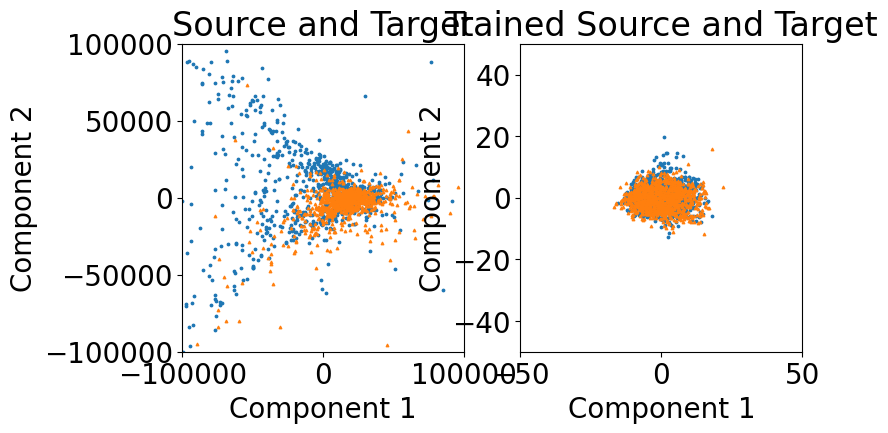

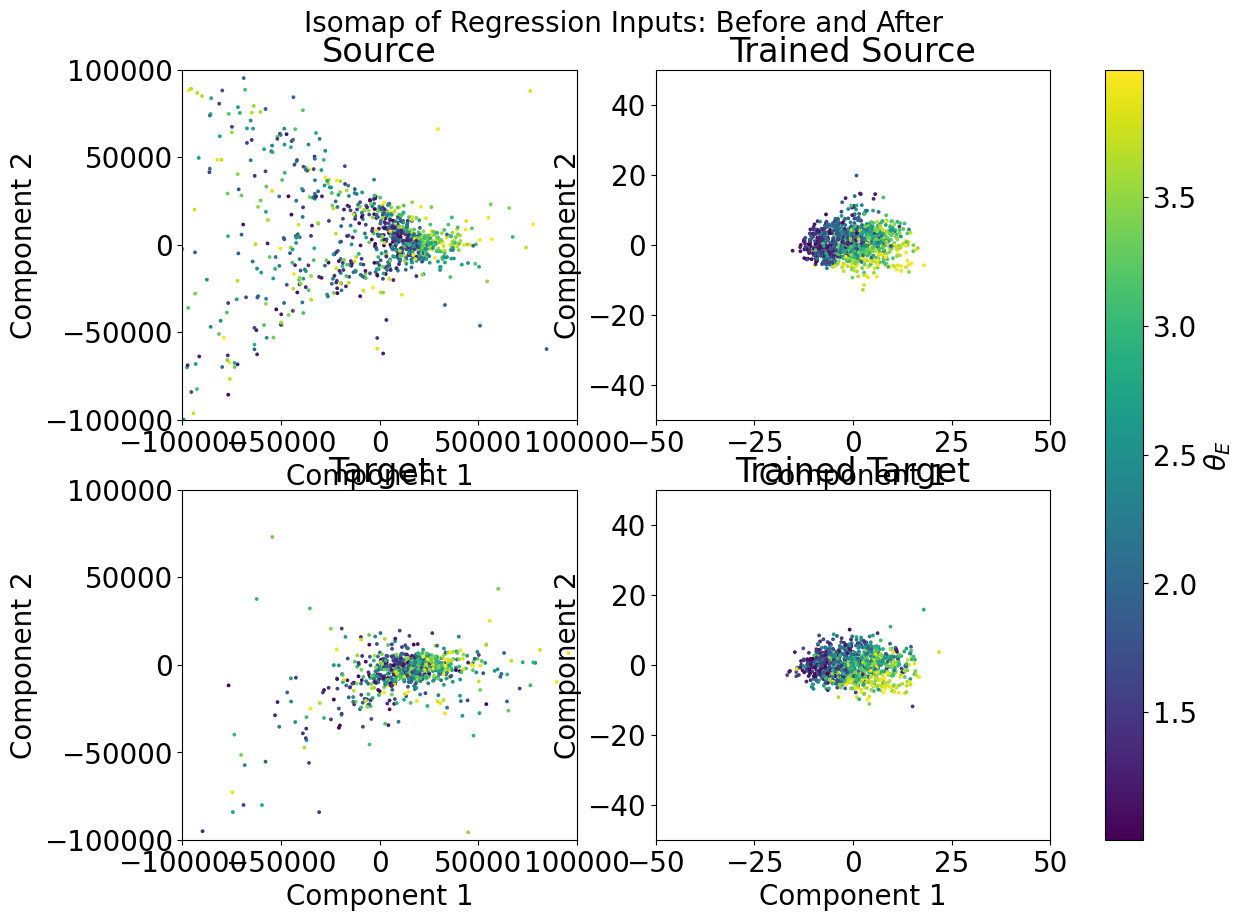

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: title={'center': 'Source and Target'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Trained Source and Target'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object),
 <Figure size 1400x1000 with 5 Axes>,
 array([[<Axes: title={'center': 'Source'}, xlabel='Component 1', ylabel='Component 2'>,
         <Axes: title={'center': 'Trained Source'}, xlabel='Component 1', ylabel='Component 2'>],
        [<Axes: title={'center': 'Target'}, xlabel='Component 1', ylabel='Component 2'>,
         <Axes: title={'center': 'Trained Target'}, xlabel='Component 1', ylabel='Component 2'>]],
       dtype=object))

In [110]:
show_isomaps(source_iso, target_iso, trained_source_iso, trained_target_iso, source_labels, target_labels, mod_name, stats["epoch_no"], 100000, 50)

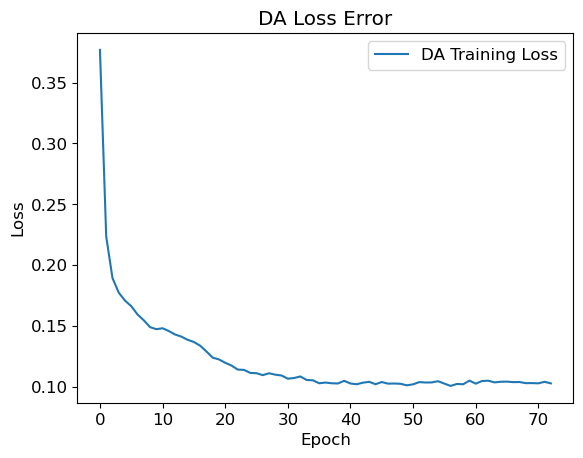

In [13]:
# Classifier
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

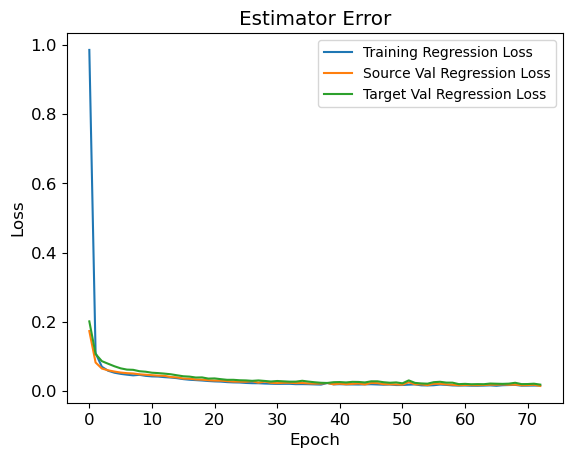

In [14]:
# Estimator
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

(-1.0, 10.0)

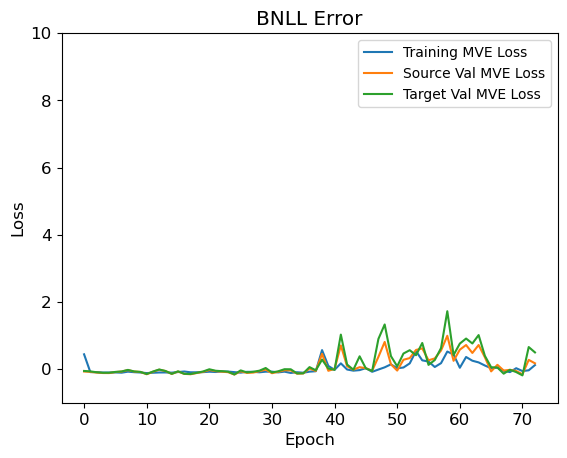

In [15]:
# Estimator
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-1, 10)

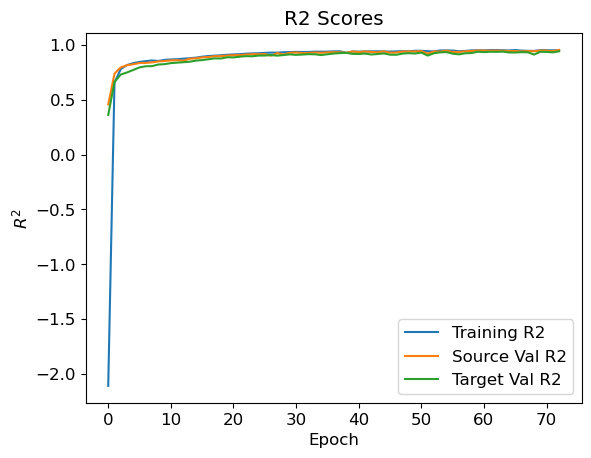

In [16]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()

Source R2 Score is 0.9535


Text(0.5, 1.0, 'MMD | Source | R2: 0.954')

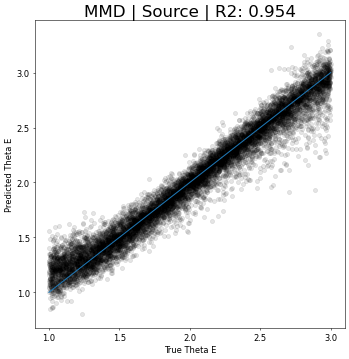

In [17]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Source | BNLL: 1.666')

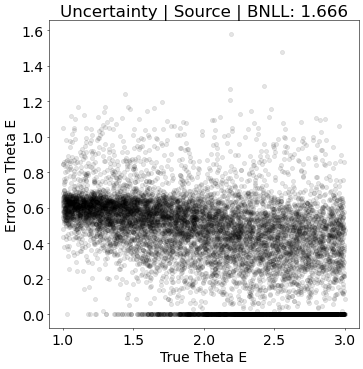

In [18]:
plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | BNLL: {0:.3f}'.format(np.mean(lbnll_source)))

Target R2 Score is 0.9394


Text(0.5, 1.0, 'MMD | Target | R2: 0.939')

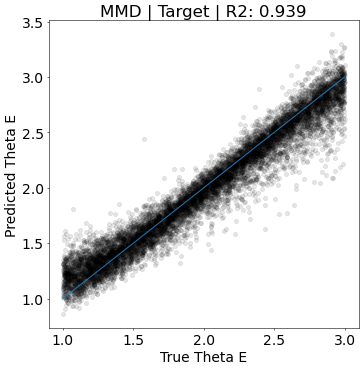

In [19]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Target | BNLL: 2.447')

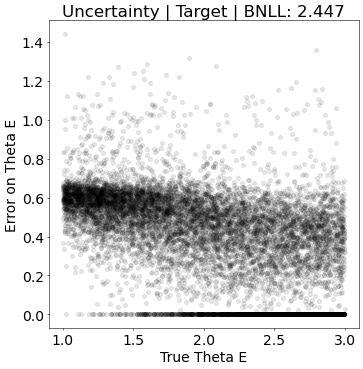

In [20]:
plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | BNLL: {0:.3f}'.format(np.mean(lbnll_target)))

In [21]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

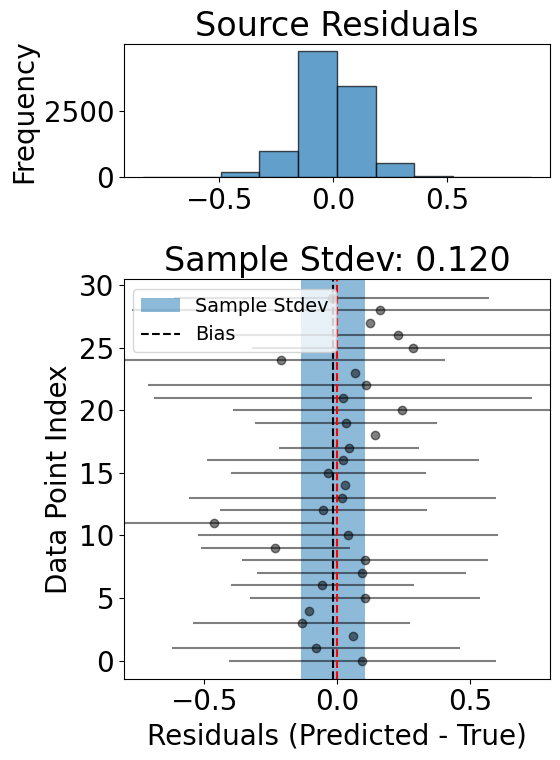

In [22]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Source Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

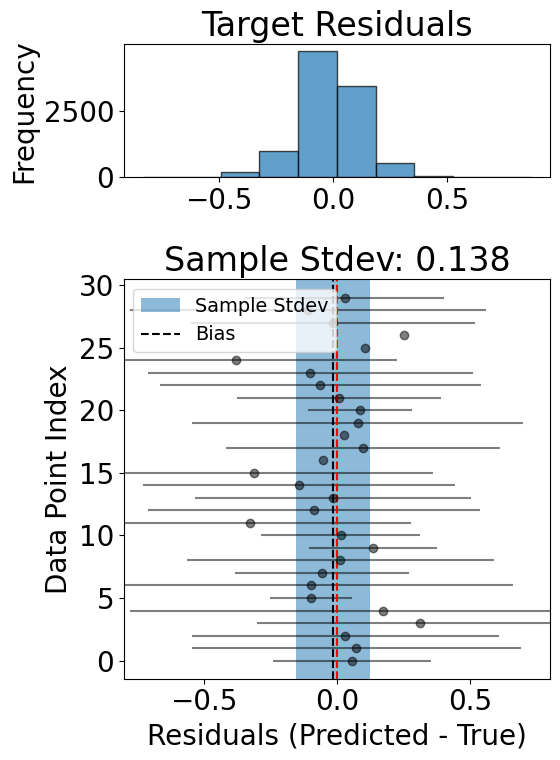

In [23]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Target Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

In [80]:
preds

array([1.30214167, 2.98077202, 2.00425458, ..., 0.95970899, 3.07219529,
       2.18891573])

In [81]:
true

array([1.69164467, 3.9343679 , 2.13911223, ..., 1.52133608, 2.09088802,
       2.36884522])

3.9343678951263428
2.980772018432617


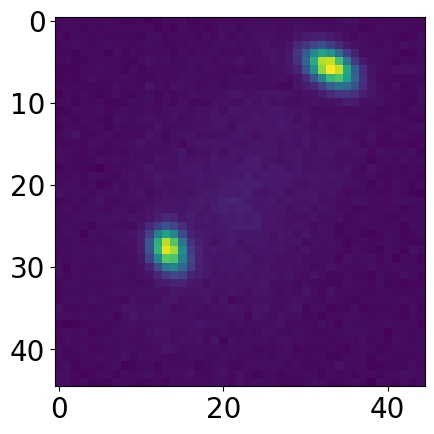

In [82]:
i = 0
b = 0
plt.imshow(imgs[idx][i, b, :, :])
print(true[idx][0])
print(preds[idx][0])

1.154159426689148
2.234156370162964


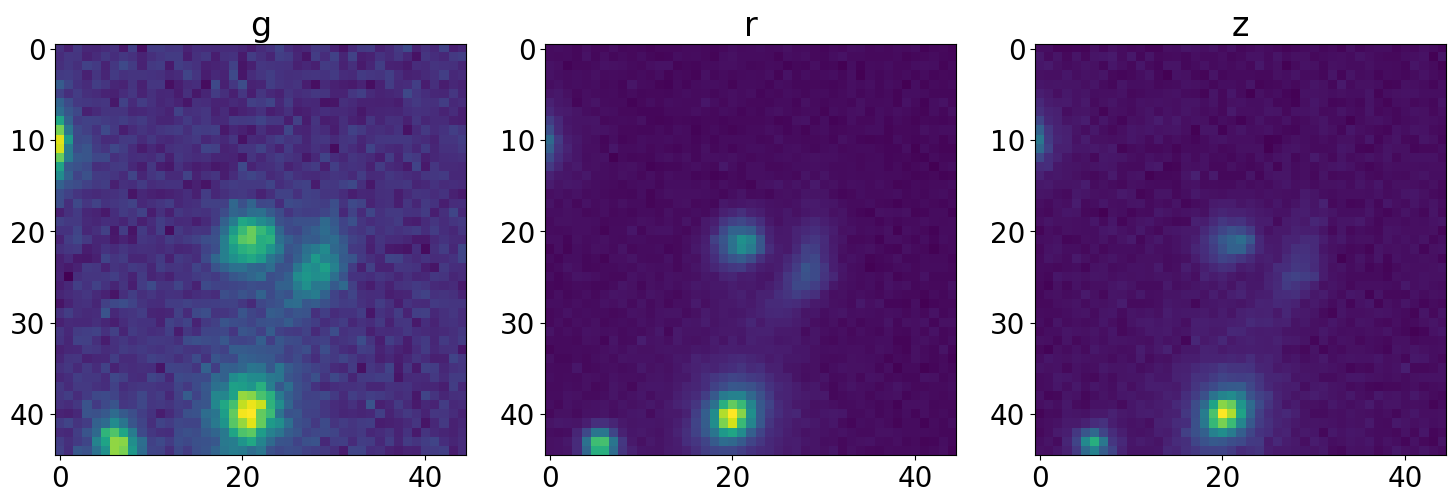

In [117]:
i = 134
# Create a figure with 3 subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# First subplot
axs[0].imshow(imgs[idx][i, 0, :, :])
axs[0].set_title('g')

# Second subplot
axs[1].imshow(imgs[idx][i, 1, :, :])
axs[1].set_title('r')

# Third subplot
axs[2].imshow(imgs[idx][i, 2, :, :])
axs[2].set_title('z')

# Adjust layout to prevent overlap
plt.tight_layout()

print(true[idx][i])
print(preds[idx][i])
# Show the plot
plt.show()

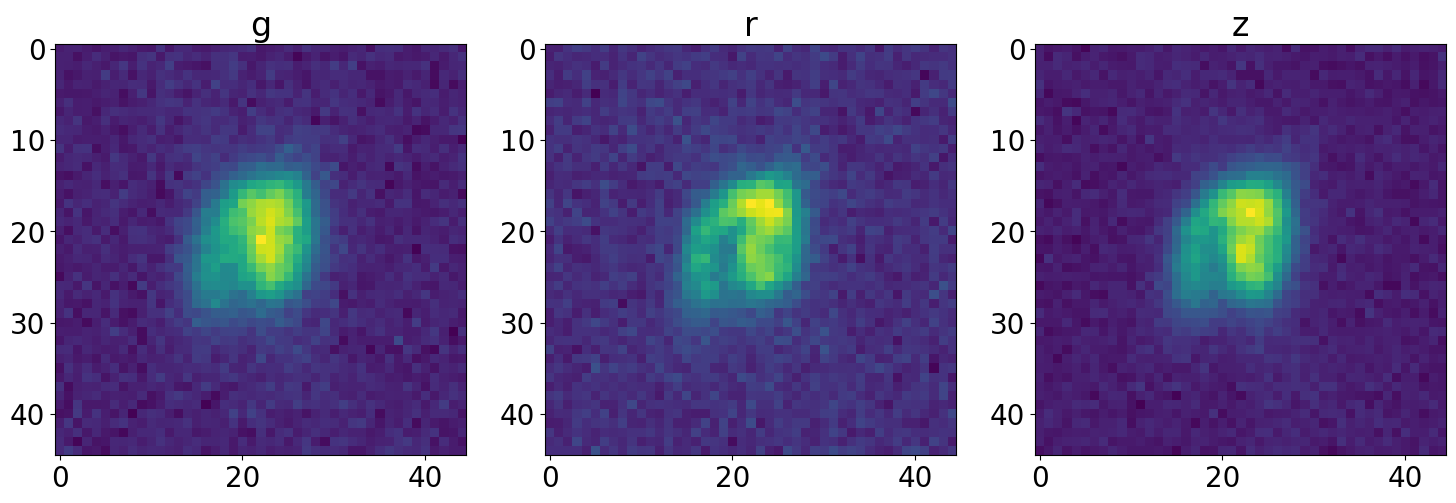

In [105]:
i = 16
# Create a figure with 3 subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# First subplot
axs[0].imshow(source_data[i, 0, :, :])
axs[0].set_title('g')

# Second subplot
axs[1].imshow(source_data[i, 1, :, :])
axs[1].set_title('r')

# Third subplot
axs[2].imshow(source_data[i, 2, :, :])
axs[2].set_title('z')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()